In [1]:
# Switch any checks to assertions for script use

# Test with error dataset
# Version control of data
# Version control of models
# Category minimums by statistical power analysis
# Reclassify text columns with many unique values
# Fix histogram binning to be dynamic based on unique values and accurate
# make dictionary of correlated columns in pre-split

# Setup

#### Imports

In [2]:
import os
import sys
import joblib
import json
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    RocCurveDisplay, PrecisionRecallDisplay, roc_auc_score, average_precision_score
)
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

from pathlib import Path
from IPython.display import HTML, display

from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler

from scipy.stats import fisher_exact

import warnings

# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.linear_model import LogisticRegression


#### Notebook Configuration

In [3]:
warnings.filterwarnings('ignore')
np.set_printoptions(precision=4, suppress=True)
pd.set_option('display.max_columns', 120)
pd.set_option('display.width', 160)

# Pretty plots
plt.rcParams["figure.figsize"] = (6, 5)
sns.set_context("notebook")

#### Constants

In [4]:
SEED = 42 # Random seed for reproducibility

# Split Ratios
TRAIN_SIZE = 0.8  # Proportion of data for training set
VAL_SIZE = 0.1  # Proportion of data for validation set
TEST_SIZE = 0.1  # Proportion of data for test set

# Columns
TARGET_COL = 'is_bad'  # Target column for classification

# Filepaths
DATA_PATH = 'lending_club_dataset.csv'
SCHEMA_VALIDATION_PATH = 'schema_validation_sheet.csv'
ERROR_DATASET_PATH = 'error_dataset.csv'

# Allowed column datatypes (These are the allowed pandas dtypes for the dataset)
ALLOWED_DTYPES = ['Int64', 'float64', 'object', 'datetime64[ns]']

COL_DESCRIPTIONS = {
    "Id": "Unique identifier for the loan record",
    "is_bad": "Binary flag for loan outcome (1 = bad/defaulted, 0 = good)",
    "emp_title": "Borrower’s job title as provided on the application",
    "emp_length": "Length of borrower’s employment in months",
    "home_ownership": "Type of home ownership reported by borrower (e.g., RENT, OWN, MORTGAGE)",
    "annual_inc": "Annual income of the borrower",
    "verification_status": "Whether the borrower’s income was verified",
    "pymnt_plan": "Indicates if the borrower has a payment plan arrangement",
    "Notes": "Free-text notes or additional information provided by borrower",
    "purpose_cat": "Categorized version of the loan purpose field",
    "purpose": "Borrower’s stated purpose for taking the loan",
    "zip_code": "First three digits of borrower’s zip code",
    "addr_state": "State of residence of the borrower",
    "debt_to_income": "Borrower’s debt-to-income ratio",
    "delinq_2yrs": "Number of borrower’s past-due events in last 2 years",
    "earliest_cr_line": "Date of borrower’s earliest reported credit line",
    "inq_last_6mths": "Number of credit inquiries in the last 6 months",
    "mths_since_last_delinq": "Months since the borrower’s last delinquency",
    "mths_since_last_record": "Months since the borrower’s last public record",
    "open_acc": "Number of currently open credit accounts",
    "pub_rec": "Number of derogatory public records (e.g., bankruptcies, judgments)",
    "revol_bal": "Total revolving credit balance across accounts",
    "revol_util": "Revolving credit utilization rate (balance divided by credit limits)",
    "total_acc": "Total number of credit accounts",
    "initial_list_status": "Status of the loan when it was first listed (e.g., f = fractional, w = whole loan)",
    "collections_12_mths_ex_med": "Number of collections in the past 12 months excluding medical",
    "mths_since_last_major_derog": "Months since most recent major derogatory public record",
    "policy_code": "Internal code used by Lending Club to identify the policy version"
}

# Notebook Variables

In [5]:
num_cols = []
cat_cols = []

# Loading the Dataset, Schema Validation Sheet, Error set, and Populating Column Lists

In [6]:
# Utility: safe read CSV with basic dtype hints
def read_csv_safely(path: str) -> pd.DataFrame:
    if not os.path.exists(path):
        raise FileNotFoundError(f"Dataset not found at {path}. Please ensure the CSV is in the workspace root.")
    # Low-memory to reduce dtype inference churn
    return pd.read_csv(path, low_memory=False)

# Load dataset
try:
    df_raw = read_csv_safely(DATA_PATH)
    print("Loaded dataset with shape:", df_raw.shape)
except Exception as e:
    print("Failed to load dataset:", e)
    raise

# Load validation schema
try:
    df_schema_validation = read_csv_safely(SCHEMA_VALIDATION_PATH)
    print("Loaded dataset with shape:", df_schema_validation.shape)
except Exception as e:
    print("Failed to load dataset:", e)
    raise

# Load error dataset
# try:
#     df_error = read_csv_safely(ERROR_DATASET_PATH)
#     print("Loaded dataset with shape:", df_error.shape)
# except Exception as e:
#     print("Failed to load dataset:", e)
#     raise

# Column classification based on schema
for col in df_schema_validation['column']:
    data_type = df_schema_validation.loc[df_schema_validation['column'] == col, 'data_type'].values[0]
    if data_type == "Discrete" or data_type == "Ratio":
        num_cols.append(col)
    if data_type == "Nominal" or data_type == "Ordinal":
        cat_cols.append(col)

Loaded dataset with shape: (10000, 28)
Loaded dataset with shape: (28, 9)


# Helper Functions

#### Individual Column Description

In [7]:
# get individual column description
def describe_column(df: pd.DataFrame, col: str, df_schema: pd.DataFrame = df_schema_validation):
    print(f"Data Type: {df_schema.loc[df_schema['column'] == col, 'data_type'].values[0]}")

    print(f"Missing Values: {df[col].isnull().sum()}")
    print(f"Unique Values: {df[col].nunique()}")

    try:
        print(f"Min Value: {df[col].min()}")
        print(f"Max Value: {df[col].max()}")
    except:
        pass

    print(df[col].value_counts(dropna=False).head(10))
    print()
    print(df[col].describe(include='all'))
    print()
    print(df[col].dtype.name)

#### Display colored text

In [8]:
def green_text(text: str):
    display(HTML(f"<span style='color: green; font-weight: bold;'>{text}</span>"))

def red_text(text: str):
    display(HTML(f"<span style='color: red; font-weight: bold;'>{text}</span>"))

#### Print column descriptions

In [9]:
def get_col_description(col):
    if col in COL_DESCRIPTIONS:
        return COL_DESCRIPTIONS[col]
    else:
        return "Column not in dataset."

#### Detect outliers by IQR

In [10]:
def detect_outliers_iqr(df: pd.DataFrame, col: str):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    return outliers, lower_bound, upper_bound

#### Detect rare categories in feature column

In [11]:
def detect_rare_categories(df, col, min_count=None, min_freq=None):

    counts = df[col].value_counts()
    total = len(df)

    if min_count is not None:
        rare = counts[counts < min_count]
    
    return rare

#### Calculate profit saved

In [12]:
def calculate_profit_saved(df: pd.DataFrame, interest_rate = 0.05):
    
    df["revenue"] = 0
    df["revenue"] = np.where(df["is_bad"] == 0, df["debt_from_revols"]*interest_rate, df["debt_from_revols"]*-1)
    revenue_total = X_test["revenue"].sum()
    print(f"Total revenue on test set: ${revenue_total:,.2f}")
    print(df[df["pred"] == 0]["revenue"].sum())

# Visualizations

In [13]:
def scatter_plot(df: pd.DataFrame, x_col: str, y_col: str, xlim: tuple = None, ylim: tuple = None, figsize=(8, 6)):
    # Scatter plot between two numerical columns
    plt.figure(figsize=figsize)
    plt.scatter(df[x_col], df[y_col], alpha=0.6, edgecolor='k')
    plt.title(f"Scatter Plot: {x_col} vs {y_col}")
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.grid(True)
    # Limit the ranges of axes

    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    plt.show()

In [14]:
def dual_histogram(df: pd.DataFrame, col1: str, col2: str):
    # Dual histogram between two numerical columns
    plt.figure(figsize=(8, 6))
    plt.hist(df[col1], bins=50, alpha=0.5, label=col1, edgecolor='black')
    plt.hist(df[col2], bins=50, alpha=0.5, label=col2, edgecolor='black')
    plt.title(f"Histogram of {col1} and {col2}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.show()

In [15]:
def histogram(df: pd.DataFrame, col: str, num_bins: int = None, figsize=(20,3), v_lines: list | None = None):
    # Histogram for a numerical column
    df_display = df[[col]].copy()
    df_display.sort_values(by=col, inplace=True)

    if num_bins is None:
        num_bins = min(100, df_display[col].nunique()+2)

    plt.figure(figsize=figsize)
    plt.hist(df_display[col].dropna(), bins=num_bins, edgecolor='k', alpha=0.7)
    plt.title(f"{col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")    

    # Add vertical lines if provided
    if v_lines is not None:
        for v in v_lines:
            if v is not None:
                plt.axvline(x=v, color="red", linestyle="--", linewidth=1)

    plt.tick_params(axis='x', rotation=90)
    plt.show()

# Statistical Tests

#### Fisher's Exact Test

In [16]:
def fisher_exact_test(df: pd.DataFrame, feature_col: str, positive_feature: int, target_col: str):
    contingency_table = pd.crosstab(df[feature_col] == positive_feature, df[target_col])

    print("Contingency table:\n", contingency_table)

    # Fisher's exact test
    odds_ratio, p_value = fisher_exact(contingency_table)

    print(f"Fisher's Exact Test odds ratio: {odds_ratio:.4f}")
    print(f"p-value: {p_value:.4g}")

# Pre-split Data Validations and Transformations

#### Create dataframe df_clean

In [17]:
df_clean = df_raw.copy()

#### Check that all columns in dataset are present in schema validation

In [18]:
def check_cols_present(df: pd.DataFrame, df_schema: pd.DataFrame):
    
    schema_cols = df_schema['column'].tolist()

    cols_missing_from_schema = set(df.columns) - set(schema_cols)
    if cols_missing_from_schema:
        print(f"Columns not present in schema but in dataset: {list(cols_missing_from_schema)}")
    cols_missing_from_dataframe = set(schema_cols) - set(df.columns)
    if cols_missing_from_dataframe:
        print(f"Columns present in schema but not in dataset: {list(cols_missing_from_dataframe)}")

check_cols_present(df_clean, df_schema_validation)

#### Find problematic values when trying to convert column to target data type

In [19]:
def find_problematic_values_for_conversion(df: pd.DataFrame, df_schema_val: pd.DataFrame):
    df_col_checks = df.copy()
    cols_with_issues = {}

    for col in df_col_checks.columns:

        if df_col_checks[col].dtype.name != df_schema_val.loc[df_schema_val['column'] == col, 'expected_dtype'].values[0]:

            # for dtypes starting as object, int64, and float64 that will be converted to Int64
            if df_schema_val.loc[df_schema_val['column'] == col, 'expected_dtype'].values[0] == "Int64":        
                try:
                    # Attempt conversion directly to Int64
                    df_col_checks[col] = df_col_checks[col].astype("Int64")
                except Exception:
                    # Anything that can't be coerced into Int64 is problematic
                    bad_mask = pd.to_numeric(df_col_checks[col], errors="coerce").isna()
                    problematic = df_col_checks.loc[bad_mask, col].unique().tolist()
                    cols_with_issues[col] = problematic

            # for dtypes starting as object that will be converted to datetime
            if df_schema_val.loc[df_schema_val['column'] == col, 'expected_dtype'].values[0] == "datetime64[ns]":
                try:
                    # Attempt conversion directly to datetime
                    df_col_checks[col] = pd.to_datetime(df_col_checks[col], format="%m/%d/%y")
                except Exception:
                    # Anything that can't be coerced into datetime is problematic
                    bad_mask = pd.to_datetime(df_col_checks[col], format="%m/%d/%y", errors="coerce").isna()
                    problematic = df_col_checks.loc[bad_mask, col].unique().tolist()
                    cols_with_issues[col] = problematic

    for k,v in cols_with_issues.items():
        print(f"Column {k} has problematic values when attempting to convert: {v}")

find_problematic_values_for_conversion(df_clean, df_schema_validation)

Column emp_length has problematic values when attempting to convert: ['na']


#### Fixing specific columns with problematic values in df_raw

In [20]:
# Fixing "na" values in "emp_length"
df_clean["emp_length"] = df_clean["emp_length"].replace("na", pd.NA)

#### Convert columns to target data type in df_clean

Since problematic values have been fixed in df_clean, the following cell should run without errors

In [21]:
# Transform column types based on schema validation
for col in df_clean.columns:
    if df_clean[col].dtype.name != df_schema_validation.loc[df_schema_validation['column'] == col, 'expected_dtype'].values[0]:

        if df_schema_validation.loc[df_schema_validation['column'] == col, 'expected_dtype'].values[0] == "Int64":            
            df_clean[col] = df_clean[col].astype("Int64")

        if df_schema_validation.loc[df_schema_validation['column'] == col, 'expected_dtype'].values[0] == "datetime64[ns]":
            
            if col == "earliest_cr_line":
                df_clean[col] = pd.to_datetime(df_clean[col], format="%m/%d/%y")

#### Confirm that there are no columns that do match intended dtype

In [22]:
for col in df_clean.columns:
    if df_clean[col].dtype.name != df_schema_validation.loc[df_schema_validation['column'] == col, 'expected_dtype'].values[0]:
        print(col)

    if df_clean[col].dtype.name not in ALLOWED_DTYPES:
        print(f"Column {col} has unexpected dtype {df_clean[col].dtype.name}")

#### Check that values in each column are within ranges and allowed values prescribed in schema validation

In [23]:
def check_against_schema(df: pd.DataFrame, schema_df: pd.DataFrame):
    issues = []

    for _, row in schema_df.iterrows():
        col = row['column']
        unique_min = row['unique_min']
        unique_max = row['unique_max']
        min_allowed = row['min_allowed']
        max_allowed = row['max_allowed']
        allowed_values = row['allowed_values']
        
        if col in df.columns:            
            
            #unique min
            if unique_min != "na":
                unique_count = df[col].nunique()
                if unique_count < int(unique_min):
                    issues.append(f"{col} has a unique count {unique_count} less than minimum {unique_min}.")

            #unique max
            if unique_max != "na":
                unique_count = df[col].nunique()
                if unique_count > int(unique_max):
                    issues.append(f"{col} has a unique count {unique_count} greater than maximum {unique_max}.")

            #allowed numerical values``
            if df[col].dtype.name in ["Int64", "float64"]:
                if min_allowed != "na":
                    min_value = df[col].min()
                    unallowed = df[col][df[col] < int(min_allowed)]
                    if not unallowed.empty:
                        issues.append(f"{col} has {len(unallowed)} values {sorted(set(unallowed.tolist()))} less than {min_allowed}.")

                if max_allowed != "na":
                    max_value = df[col].max()
                    unallowed = df[col][df[col] > int(max_allowed)]
                    if not unallowed.empty:
                        issues.append(f"{col} has {len(unallowed)} values {sorted(set(unallowed.tolist()))} greater than {max_allowed}.")

            #allowed date values
            if df[col].dtype.name == "datetime64[ns]":
                if min_allowed != "na":
                    min_allowed = pd.to_datetime(min_allowed, format="%Y%m%d")
                    unallowed = df[col][df[col] < min_allowed]
                    if not unallowed.empty:
                        issues.append(f"{col} has {len(unallowed)} values {sorted(set(unallowed.tolist()))} less than {min_allowed}.")

                if max_allowed != "na":
                    max_allowed = pd.to_datetime(max_allowed, format="%Y%m%d")
                    unallowed = df[col][df[col] > max_allowed]                    
                    if not unallowed.empty:
                        issues.append(f"{col} has {len(unallowed)} values {sorted(set(unallowed.tolist()))} greater than {max_allowed}.")

            #allowed categorical values
            if allowed_values != "na" and df[col].dtype.name == "object":
                allowed_set = set(allowed_values.split(","))
                actual_set = set(df[col].dropna().unique())
                disallowed = list(actual_set - allowed_set)
                if disallowed:
                    issues.append(f"{col} has disallowed values: {disallowed}.")

    return issues

check_against_schema(df_clean, df_schema_validation)

['emp_length has a unique count 13 greater than maximum 10.',
 'emp_length has 8 values [11, 22, 33] greater than 10.',
 "earliest_cr_line has 26 values [Timestamp('2050-12-01 00:00:00'), Timestamp('2056-09-01 00:00:00'), Timestamp('2059-06-01 00:00:00'), Timestamp('2062-09-01 00:00:00'), Timestamp('2063-01-01 00:00:00'), Timestamp('2063-09-01 00:00:00'), Timestamp('2064-09-01 00:00:00'), Timestamp('2064-10-01 00:00:00'), Timestamp('2065-05-01 00:00:00'), Timestamp('2065-09-01 00:00:00'), Timestamp('2066-06-01 00:00:00'), Timestamp('2066-12-01 00:00:00'), Timestamp('2067-04-01 00:00:00'), Timestamp('2067-06-01 00:00:00'), Timestamp('2067-07-01 00:00:00'), Timestamp('2067-09-01 00:00:00'), Timestamp('2067-11-01 00:00:00'), Timestamp('2068-01-01 00:00:00'), Timestamp('2068-08-01 00:00:00'), Timestamp('2068-09-01 00:00:00'), Timestamp('2068-12-01 00:00:00')] greater than 2008-11-02 00:00:00.",
 'revol_util has 1 values [100.6] greater than 100.']

#### Fix columns with specific data range problems

##### fixing "emp_length"

In [24]:
rows_with_emp_length_issues = df_clean[df_clean["emp_length"].isin([11,22,33])]
print(f"Rows with emp_length issues: {len(rows_with_emp_length_issues)}")
print(f"Number of positive is_bad values in rows_with_emp_length_issues: {rows_with_emp_length_issues['is_bad'].sum()}")
print(f"Total number of positive is_bad values in full dataset: {df_clean['is_bad'].sum()}")
print(f"Percentage of rows_with_emp_length_issues against total positive values: {rows_with_emp_length_issues['is_bad'].sum() / df_clean['is_bad'].sum() * 100:.2f}%")

Rows with emp_length issues: 8
Number of positive is_bad values in rows_with_emp_length_issues: 8
Total number of positive is_bad values in full dataset: 1295
Percentage of rows_with_emp_length_issues against total positive values: 0.62%


All rows with error values in this emp_length have "is_bad" = 1. Dropping rows until cause of error can be confirmed.

In [25]:
# Drop rows with emp_length issues
print(df_clean.shape)
df_clean = df_clean[~df_clean["emp_length"].isin([11,22,33])]
print(df_clean.shape)

(10000, 28)
(9992, 28)


##### fixing "earliest_cr_line" and converting to years since earliest credit line

<Axes: >

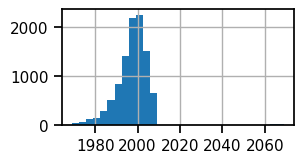

In [26]:
df_clean["earliest_cr_line"].hist(bins=30, figsize=(3, 1.5))

<Axes: >

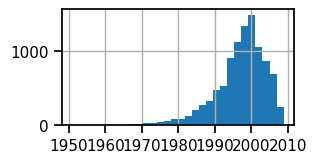

In [27]:
# any dates after cutoff date will have 100 years subtracted
dates = pd.to_datetime(df_clean["earliest_cr_line"], format="%m/%d/%y", errors="coerce")
cutoff = pd.Timestamp(df_schema_validation.loc[df_schema_validation['column'] == "earliest_cr_line", 'max_allowed'].values[0])
dates = dates.where(dates < cutoff, dates - pd.DateOffset(years=100))
df_clean["earliest_cr_line"] = dates
df_clean["earliest_cr_line"].hist(bins=30, figsize=(3, 1.5))

Converting earliest_cr_line to years since earliest credit line

In [28]:
# convert earliest_cr_line to years since earliest credit line based on max date in earliest_cr_line
max_date = df_clean['earliest_cr_line'].max()
df_clean['earliest_cr_line'] = (max_date - df_clean['earliest_cr_line']).dt.days // 365
df_clean['earliest_cr_line'] = df_clean['earliest_cr_line'].astype("Int64")

# Add to num_cols since it is now numerical
num_cols.append("earliest_cr_line")

# Create new columns that will represent a numerical quantity for debt

In [29]:
df_clean["debt_from_d2i_and_annual_inc"] = df_clean["debt_to_income"]/100 * df_clean["annual_inc"]
df_clean["debt_from_revols"] = df_clean["revol_bal"] * df_clean["revol_util"]/100

num_cols.append("debt_from_d2i_and_annual_inc")
num_cols.append("debt_from_revols")

# Pre-split EDA (no analyses involving features-in_relation-to-labels)

In [30]:
def summarize_near_constant_features(
    df: pd.DataFrame,
    *,
    dominant_thresh: float = 0.98,   # flag if top value covers ≥ this fraction of non-null values
    max_unique_for_flag: int | None = None,  # optionally also require unique values ≤ this number
    min_non_null: int = 5,           # skip columns with too few non-nulls
    treat_bool_as_categorical: bool = True
) -> pd.DataFrame:
    """
    Analyze columns for 'near-constant' behavior and return a summary DataFrame.

    Columns are flagged when the dominant (most frequent) value's share among non-null values
    is ≥ dominant_thresh. Optionally (if max_unique_for_flag is set), we also require that the
    number of unique non-null values ≤ max_unique_for_flag.

    Parameters
    ----------
    df : pd.DataFrame
        Input data.
    dominant_thresh : float, default 0.98
        Threshold for dominant value proportion to flag near-constant.
    max_unique_for_flag : int or None, default None
        If set, near-constant flag additionally requires unique_count ≤ this.
        (E.g., set to 2 to flag only nearly-all-0/1 columns.)
    min_non_null : int, default 5
        Skip columns with fewer than this many non-null observations.
    treat_bool_as_categorical : bool, default True
        If True, boolean columns are summarized as categoricals.

    Returns
    -------
    pd.DataFrame
        Columns:
        - column
        - dtype
        - non_null_count
        - missing_rate
        - unique_count
        - dominant_value
        - dominant_count
        - dominant_share
        - minority_count
        - variance (numeric only; else NaN)
        - std (numeric only; else NaN)
        - min_value (numeric only; else NaN)
        - max_value (numeric only; else NaN)
        - entropy_bits (Shannon entropy base-2 on value distribution)
        - is_binary_like (unique_count == 2)
        - near_constant_flag (boolean)
        - top_5_values (string formatted "value:count; …")
    """
    summaries = []

    for col in df.columns:
        s = df[col]
        non_null = s.dropna()
        non_null_count = int(non_null.shape[0])
        missing_rate = (1.0 - (non_null_count / max(1, s.shape[0])))*100

        # Handle dtype classification early so branches can use it
        is_bool = pd.api.types.is_bool_dtype(s)
        is_numeric = pd.api.types.is_numeric_dtype(s) and not (is_bool and treat_bool_as_categorical)

        # Precompute min/max for numeric columns
        if is_numeric and non_null_count > 0:
            try:
                min_value = float(non_null.astype(float).min())
                max_value = float(non_null.astype(float).max())
            except Exception:
                # Fallback in case of mixed numeric types that fail astype(float)
                min_value = float(pd.to_numeric(non_null, errors='coerce').min())
                max_value = float(pd.to_numeric(non_null, errors='coerce').max())
        else:
            min_value = np.nan
            max_value = np.nan

        # # Top-5 most common values (include NaN label consistent with helper)
        # try:
        #     top5_vals = top5_summary(s)
        # except Exception:
        #     # If helper not available for any reason, compute a simple fallback
        vc_tmp = s.value_counts(dropna=False).head(5)
        def _fmt(v):
            if pd.isna(v):
                return 'NaN'
            txt = str(v)
            return (txt[:60] + '…') if len(txt) > 60 else txt
        top5_vals = "; ".join([f"{_fmt(idx)}:{int(cnt)}" for idx, cnt in vc_tmp.items()])

        if non_null_count < min_non_null:
            # Not enough data to assess; still record info
            summaries.append({
                "column": col,
                "dtype": s.dtype.name,
                "non_null_count": non_null_count,
                "missing_rate%": missing_rate,
                "unique_count": non_null.nunique(dropna=True),
                "min_value": min_value,
                "max_value": max_value,
                "dominant_value": np.nan,
                "dominant_count": 0,
                "dominant_share": np.nan,
                "minority_count": 0,
                "variance": np.nan,
                "std": np.nan,
                "entropy_bits": np.nan,
                "is_binary_like": False,
                "near_constant_flag": False,
                "top_5_values": top5_vals,
            })
            continue

        # Value counts for frequencies
        vc = non_null.value_counts(dropna=False)
        dominant_value = vc.index[0]
        dominant_count = int(vc.iloc[0])
        unique_count = int(vc.shape[0])
        dominant_share = dominant_count / non_null_count
        minority_count = non_null_count - dominant_count

        # Entropy (base-2)
        probs = (vc / non_null_count).to_numpy()
        entropy_bits = float(-np.sum(probs * np.log2(probs))) if unique_count > 1 else 0.0

        # Numeric variance/std if applicable
        if is_numeric:
            variance = float(non_null.astype(float).var(ddof=1)) if non_null_count > 1 else 0.0
            std = float(np.sqrt(variance))
        else:
            variance = np.nan
            std = np.nan

        # Binary-like flag
        is_binary_like = (unique_count == 2)

        # Near-constant logic
        meets_share = dominant_share >= dominant_thresh
        meets_unique = True if max_unique_for_flag is None else (unique_count <= max_unique_for_flag)
        near_constant_flag = bool(meets_share and meets_unique)

        summaries.append({
            "column": col,
            "dtype": s.dtype.name,
            "non_null_count": non_null_count,
            "missing_rate%": missing_rate,
            "unique_count": unique_count,
            "min_value": min_value,
            "max_value": max_value,
            "dominant_value": dominant_value,
            "dominant_count": dominant_count,
            "dominant_share": dominant_share,
            "minority_count": minority_count,
            "variance": variance,
            "std": std,
            "entropy_bits": entropy_bits,
            "is_binary_like": is_binary_like,
            "near_constant_flag": near_constant_flag,
            "top_5_values": top5_vals,
        })

    out = pd.DataFrame(summaries)
    # Order: flags first, then by dominant_share desc, then low entropy
    # out = out.sort_values(
    #     by=["near_constant_flag", "dominant_share", "entropy_bits"],
    #     ascending=[False, False, True],
    #     kind="mergesort"
    # ).reset_index(drop=True)
    return out

df_summary = summarize_near_constant_features(df_clean)
summary_cols = ["column","dtype","missing_rate%","unique_count","min_value","max_value","dominant_value","dominant_share","variance","near_constant_flag","top_5_values"]

#### View distributions for all numerical columns

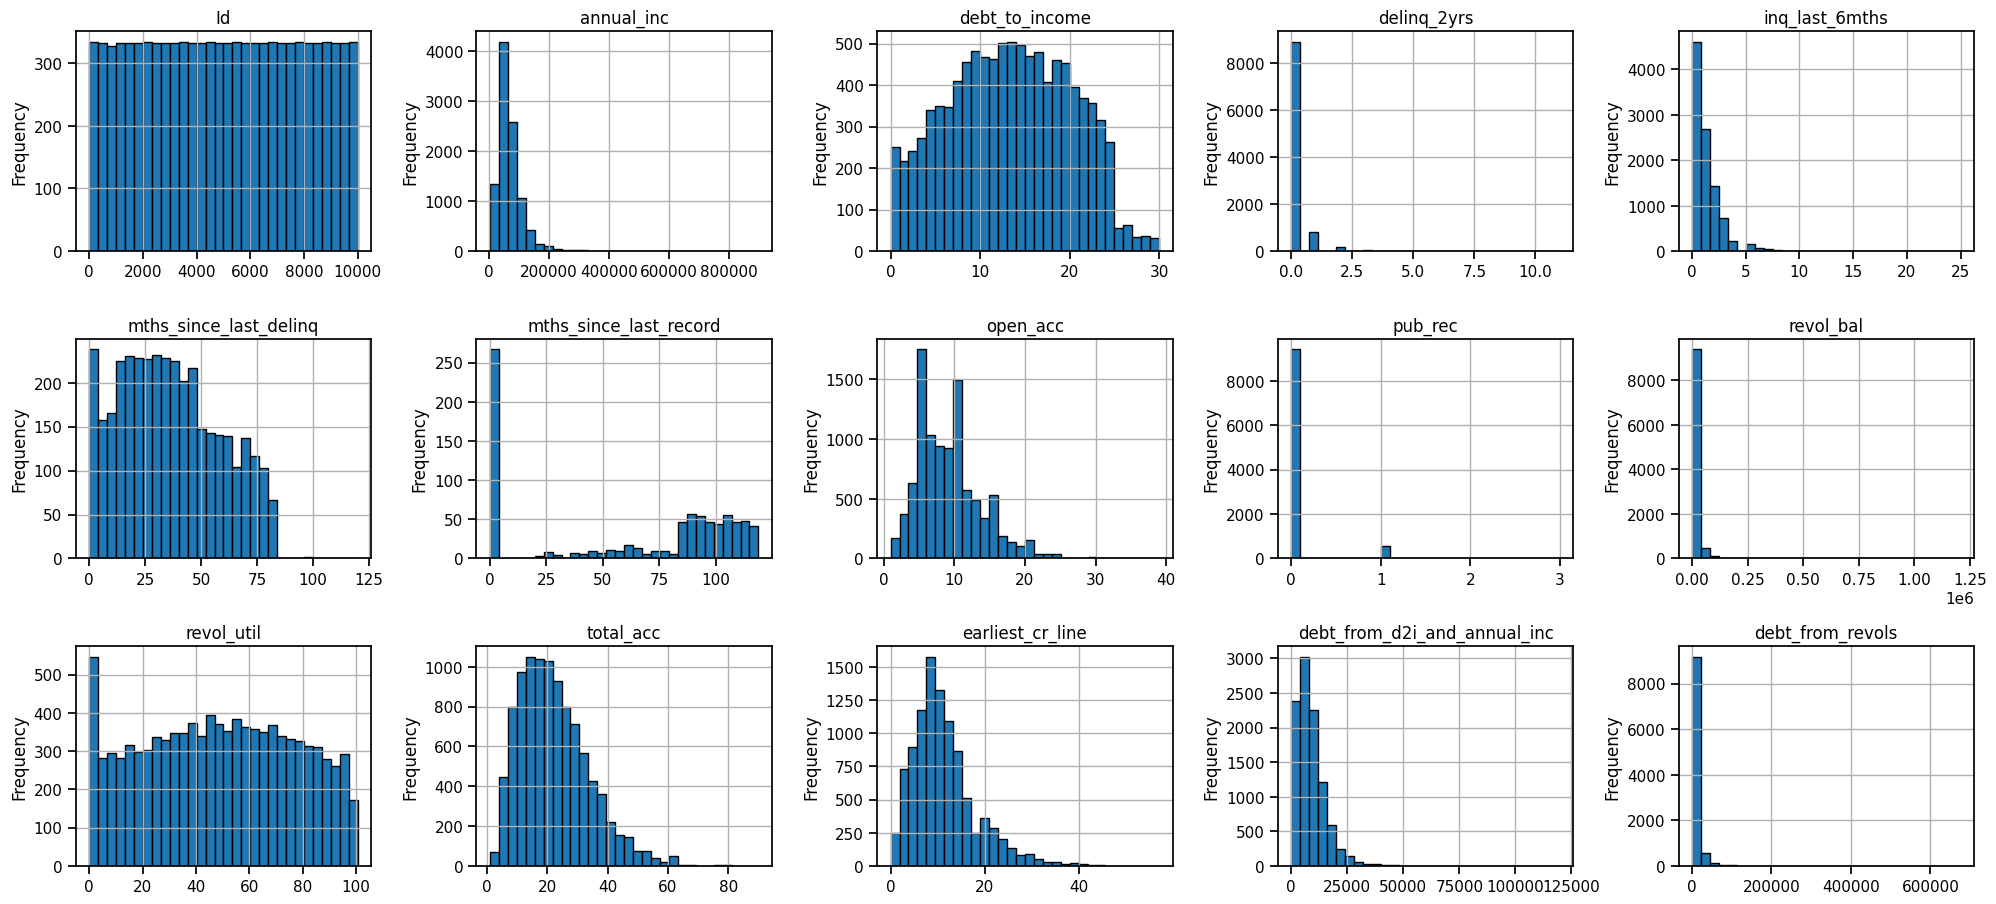

In [31]:
# Set up the grid: 3 rows × 4 columns
fig, axes = plt.subplots(4, 5, figsize=(20, 12))  
axes = axes.flatten()  # Flatten to 1D array for easy iteration

# Plot histograms for each column
for i, col in enumerate(num_cols):
    df_clean[col].hist(ax=axes[i], bins=30, edgecolor='black')
    axes[i].set_title(col)
    axes[i].set_ylabel('Frequency')
    axes[i].set_xlabel('')

# Remove unused subplots if < 12 columns
for j in range(len(num_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

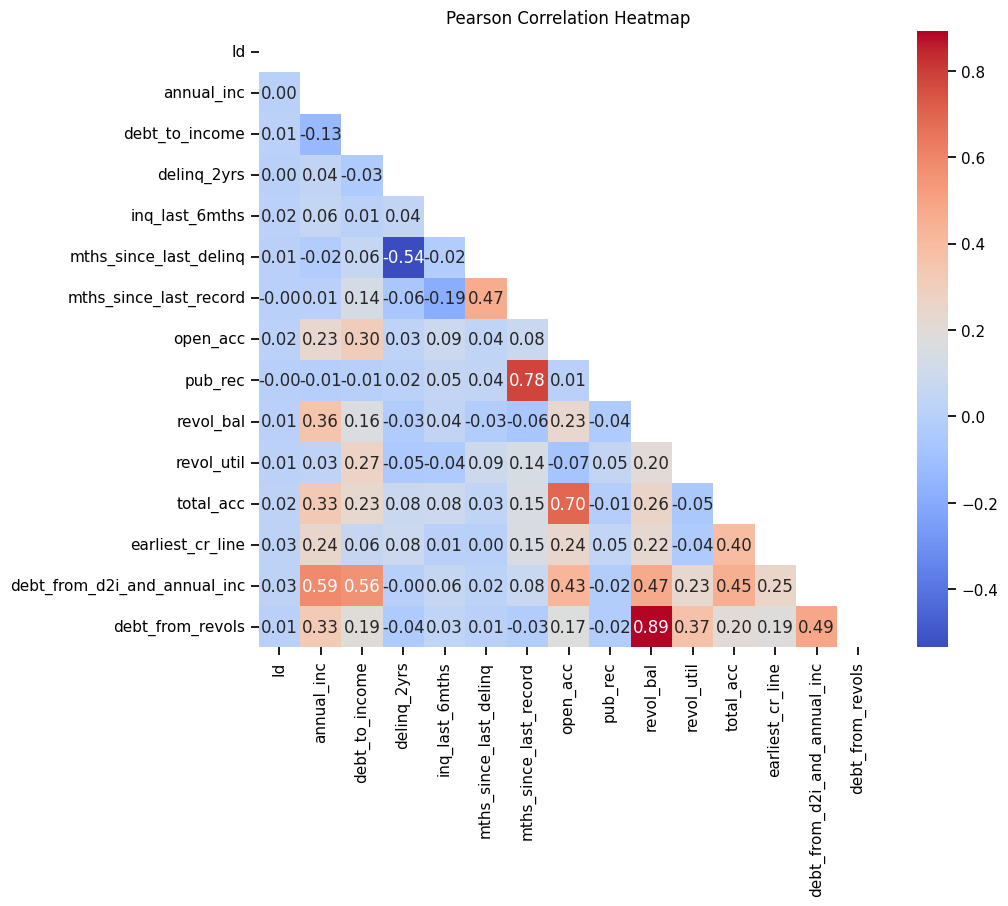

In [32]:
plt.figure(figsize=(10, 8)) 
corr_matrix = df_clean[num_cols].corr(method="pearson") 
# Select upper triangle of correlation matrix (to avoid duplicates) 
upper_tri = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(bool)) 
sns.heatmap(upper_tri, annot=True, cmap="coolwarm", fmt=".2f") 
plt.title("Pearson Correlation Heatmap") 
plt.show()

In [33]:
# Compute correlation matrix
corr_matrix = df_clean[num_cols].corr(method="pearson")

# Select upper triangle of correlation matrix (to avoid duplicates)
upper_tri = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

# Find pairs with correlation > 0.4 or < -0.4
threshold = 0.3
strong_pairs = (
    upper_tri.stack()
    .reset_index()
    .rename(columns={"level_0": "Feature1", "level_1": "Feature2", 0: "Correlation"})
)

strong_pairs = strong_pairs[
    (strong_pairs["Correlation"].abs() > threshold)
].sort_values(by="Correlation", ascending=False)

# Remove rows where Feature1 == Feature2 (self-correlation)
strong_pairs = strong_pairs[strong_pairs["Feature1"] != strong_pairs["Feature2"]]


# strong_pairs = strong_pairs[~((strong_pairs["Feature1"] == "revol_bal")& (strong_pairs["Feature2"] == "debt_from_revols"))]
# strong_pairs = strong_pairs[~((strong_pairs["Feature1"] == "annual_inc")& (strong_pairs["Feature2"] == "debt_from_d2i_and_annual_inc"))]
# strong_pairs = strong_pairs[~((strong_pairs["Feature1"] == "debt_from_d2i_and_annual_inc")& (strong_pairs["Feature2"] == "debt_from_revols"))]
# strong_pairs = strong_pairs[~((strong_pairs["Feature1"] == "debt_to_income")& (strong_pairs["Feature2"] == "debt_from_d2i_and_annual_inc"))]
# strong_pairs = strong_pairs[~((strong_pairs["Feature1"] == "revol_util")& (strong_pairs["Feature2"] == "debt_from_revols"))]

strong_pairs.reset_index(drop=True, inplace=True)

print(strong_pairs)

                        Feature1                      Feature2  Correlation
0                      revol_bal              debt_from_revols     0.891118
1         mths_since_last_record                       pub_rec     0.783968
2                       open_acc                     total_acc     0.695341
3                     annual_inc  debt_from_d2i_and_annual_inc     0.588413
4                 debt_to_income  debt_from_d2i_and_annual_inc     0.558095
5   debt_from_d2i_and_annual_inc              debt_from_revols     0.488040
6                      revol_bal  debt_from_d2i_and_annual_inc     0.473496
7         mths_since_last_delinq        mths_since_last_record     0.465476
8                      total_acc  debt_from_d2i_and_annual_inc     0.454371
9                       open_acc  debt_from_d2i_and_annual_inc     0.428138
10                     total_acc              earliest_cr_line     0.400314
11                    revol_util              debt_from_revols     0.371486
12          

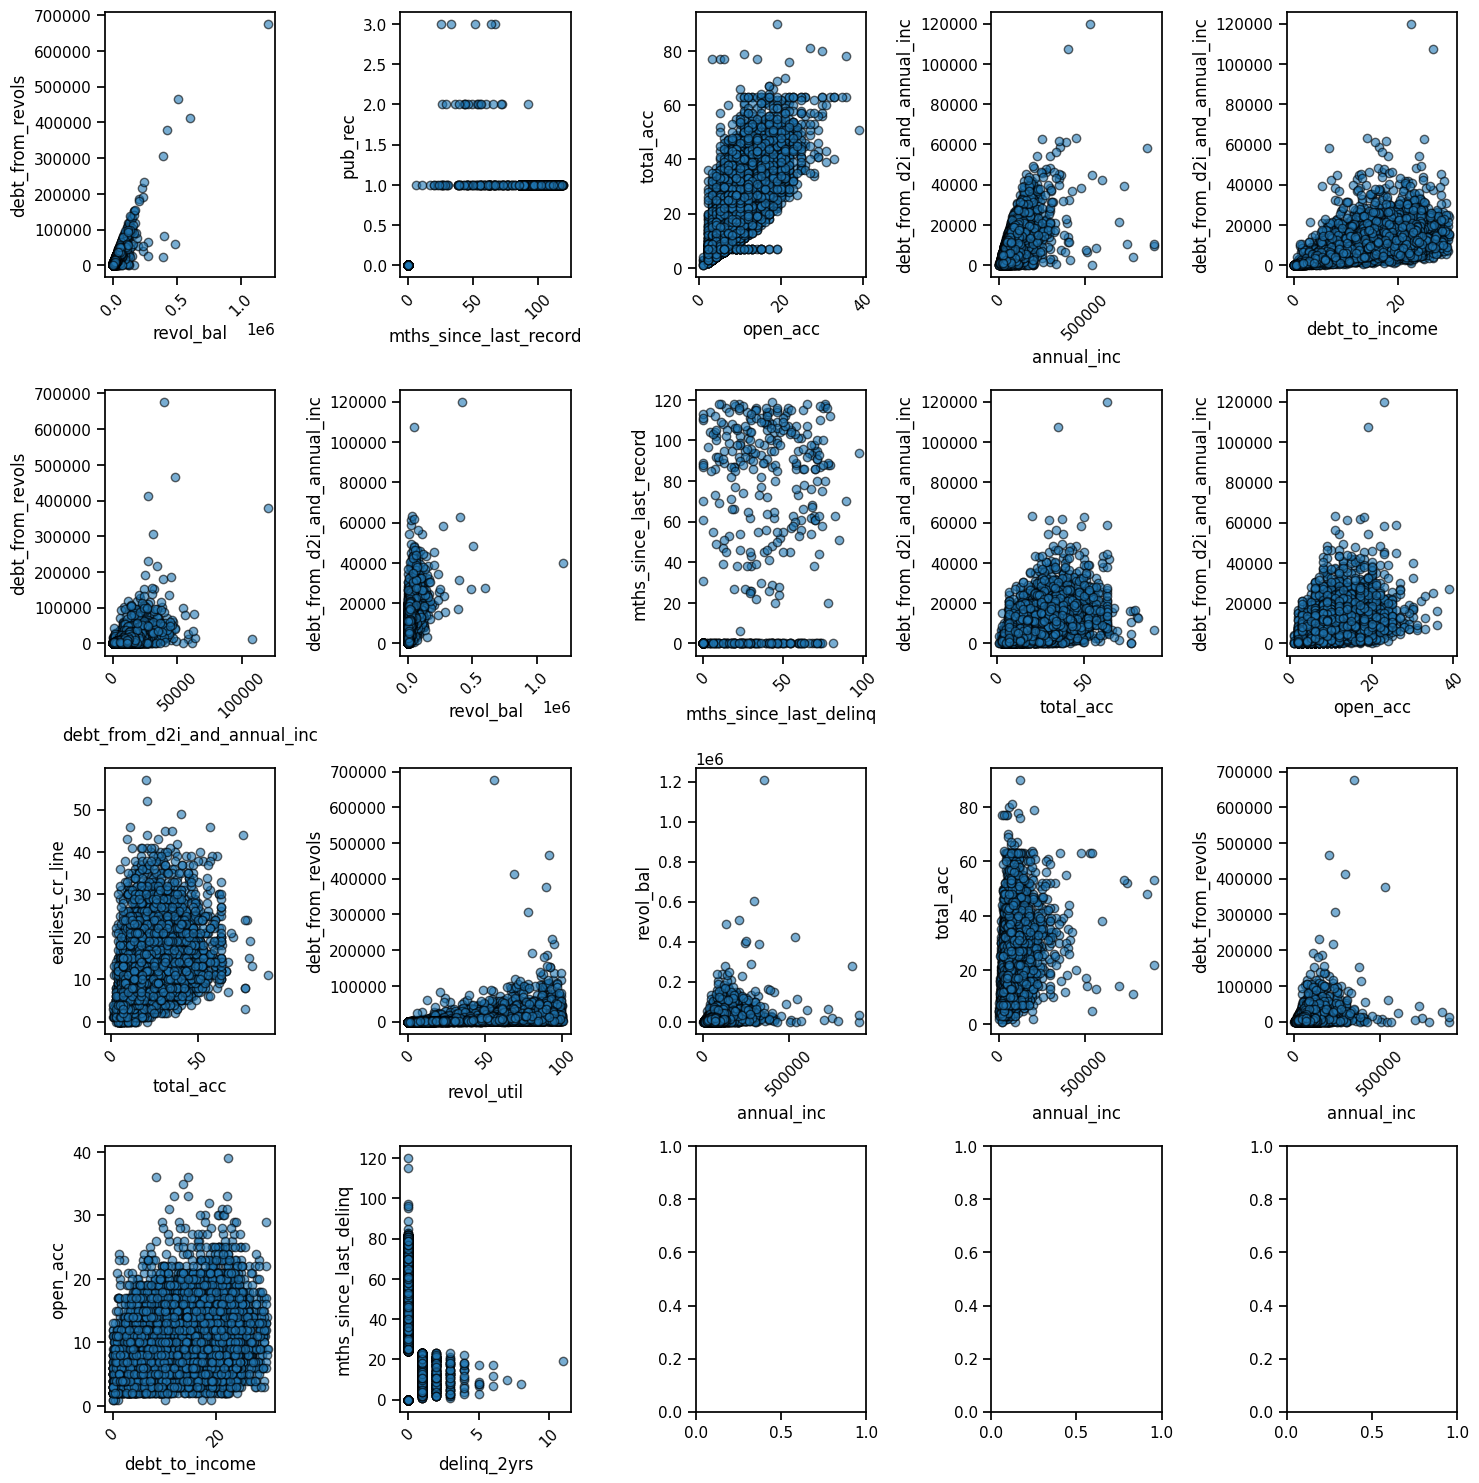

In [34]:
# Create subplots
fig, axes = plt.subplots(4, 5, figsize=(15, 15))  # 2 rows, 5 columns
axes = axes.flatten()

# Loop through rows and plot
for idx, row in strong_pairs.iterrows():
    feature1 = row["Feature1"]
    feature2 = row["Feature2"]
    
    axes[idx].scatter(df_clean[feature1], df_clean[feature2], alpha=0.6, edgecolor='k')  # x = column names, y = values    
    axes[idx].set_xlabel(feature1)
    axes[idx].set_ylabel(feature2)    
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Pre-split EDA - Individual Column Inspection and Assignment

In [35]:
good2go_pre = []
x_feature_drop_cols = []

median_imputation_cols = []
mode_imputation_cols = []
missing_imputation_cols = []

valid_correlations = {}

all_col = sorted(df_clean.columns.tolist())

#### Inspect Column function

In [36]:
def inspect_column_pre_split(col: str):

    df_summary_col = df_summary[df_summary['column'] == col][summary_cols]
    df_summary_col.dropna(inplace=True, axis=1)

    df_strong_pair_col = strong_pairs[(strong_pairs['Feature1'] == col) | (strong_pairs['Feature2'] == col)]
    df_outliers = pd.DataFrame()

    lower_bound, upper_bound = None, None
    if col in num_cols:
        df_outliers, lower_bound, upper_bound = detect_outliers_iqr(df_clean, col)

    rare = detect_rare_categories(df_clean, col, min_count=10)

    flag = {'missing': False, 'near_constant': False, 'strong_pair': False, 'outliers': False, 'rare': False}

    if df_clean[col].isna().sum() > 0:
        flag['missing'] = True
    if df_summary_col.iloc[0]['near_constant_flag'] == True:
        flag['near_constant'] = True 
    if not df_strong_pair_col.empty:
        flag['strong_pair'] = True
    if not df_outliers.empty:
        flag['outliers'] = True
    if not rare.empty:
        flag['rare'] = True

    print(f"Data Type: {df_schema_validation.loc[df_schema_validation['column'] == col, 'data_type'].values[0]}")

    if any(flag.values()) == True:

        red_text(f"Column {col} has issues: {", ".join([k for k, v in flag.items() if v])}")

        if flag['missing']:
            print(f"Column {col} has {df_clean[col].isna().sum()} missing values.")
        if flag['near_constant']:
            print(f"Column {col} is near-constant with dominant value {df_summary_col.iloc[0]['dominant_value']} covering {df_summary_col.iloc[0]['dominant_share']*100:.2f}% of non-null values.")
        if flag['strong_pair']:
            print(f"Column {col} has strong correlation pairs:")
            display(df_strong_pair_col)
        if flag['outliers']:
            print(f"Column {col} has {len(df_outliers)} outlier rows based on IQR method ({len(df_outliers[df_outliers[col] < lower_bound])} values below {lower_bound}, {len(df_outliers[df_outliers[col] > upper_bound])} values above {upper_bound}).")
        if flag['rare']:
            print(f"Column {col} has rare categories with counts less than 10:")
            display(rare)

    else:
        green_text(f"Column {col} looks good.")        

    histogram(df_clean, col, v_lines = [lower_bound, upper_bound])
    display(df_summary_col)

#### Id - Isn't a feature with relevant information, will be dropped

In [37]:
x_feature_drop_cols.append("Id")

#### Notes - If time, will work with NLP magic, but dropping for now

In [38]:
x_feature_drop_cols.append("Notes")

#### addr_state - good to go for pre-split

Data Type: Nominal


Column addr_state has rare categories with counts less than 10:


addr_state
MS    9
TN    5
NE    3
IN    3
IA    2
ID    1
ME    1
Name: count, dtype: int64

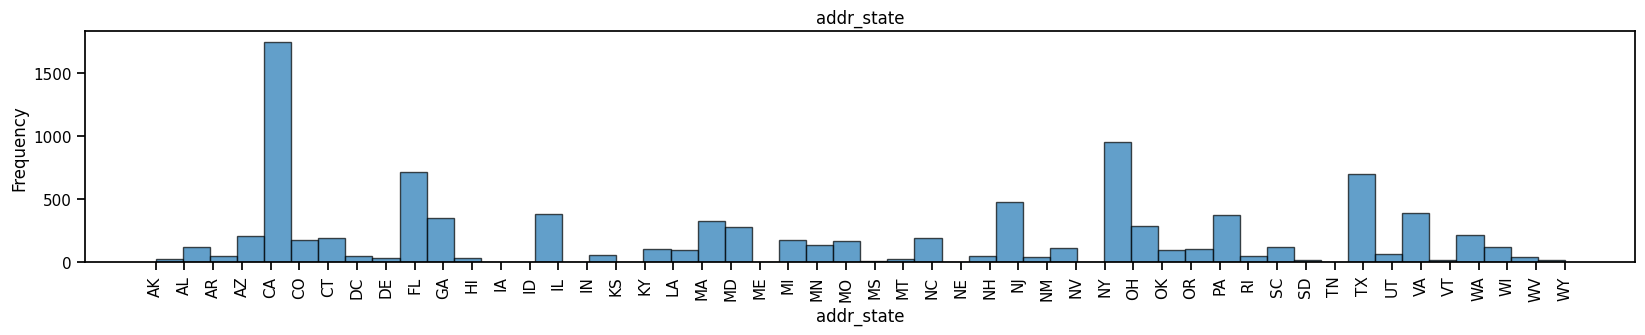

,column,dtype,missing_rate%,unique_count,dominant_value,dominant_share,near_constant_flag,top_5_values
12,addr_state,object,0.0,50,CA,0.17464,False,CA:1745; NY:957; FL:714; TX:700; NJ:482


In [39]:
inspect_column_pre_split("addr_state")

In [40]:
good2go_pre.append("addr_state")

#### annual_inc - added to median imputation, has four strong correlations

Data Type: Ratio


Column annual_inc has 1 missing values.
Column annual_inc has strong correlation pairs:


,Feature1,Feature2,Correlation
3,annual_inc,debt_from_d2i_and_annual_inc,0.588413
12,annual_inc,revol_bal,0.359756
13,annual_inc,total_acc,0.329061
14,annual_inc,debt_from_revols,0.325069


Column annual_inc has 467 outlier rows based on IQR method (0 values below -23000.0, 467 values above 145000.0).
Column annual_inc has rare categories with counts less than 10:


annual_inc
128000.0    9
104000.0    9
116000.0    9
91000.0     9
190000.0    9
           ..
127500.0    1
71136.0     1
15360.0     1
33716.0     1
70560.0     1
Name: count, Length: 1745, dtype: int64

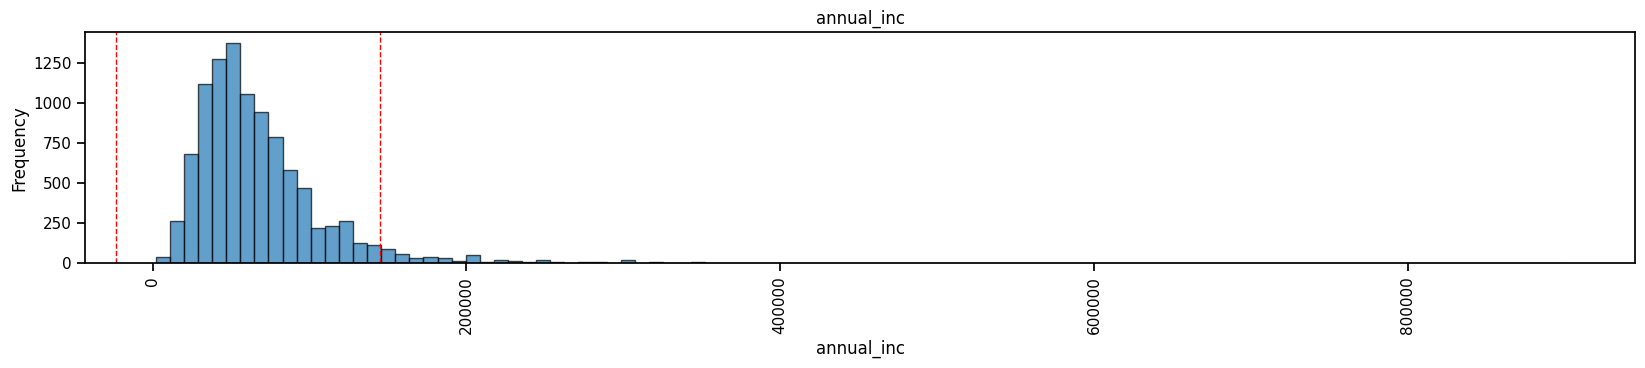

,column,dtype,missing_rate%,unique_count,min_value,max_value,dominant_value,dominant_share,variance,near_constant_flag,top_5_values
5,annual_inc,float64,0.010008,1898,2000.0,900000.0,60000.0,0.038134,2.362215e+09,False,60000.0:381; 50000.0:267; 40000.0:222; 75000.0...


In [41]:
inspect_column_pre_split("annual_inc")

debt_from_d2i_and_annual_inc is derived from annual_inc; debt_from_d2i_and_annual_inc will be dropped

revol_bal is for maximizing profit calculations and will be dropped

total_acc will be noted for it's correlation but kept for now

debt_from_revols is for maximizing profit calculations and will be dropped

In [42]:
valid_correlations["annual_inc"] = ["total_acc"]
median_imputation_cols.append("annual_inc")
good2go_pre.append("annual_inc")

#### collections_12_mths_ex_med - added to missing imputation; has 1 unique value and missing values

Data Type: Nominal


Column collections_12_mths_ex_med has 32 missing values.
Column collections_12_mths_ex_med is near-constant with dominant value 0 covering 100.00% of non-null values.


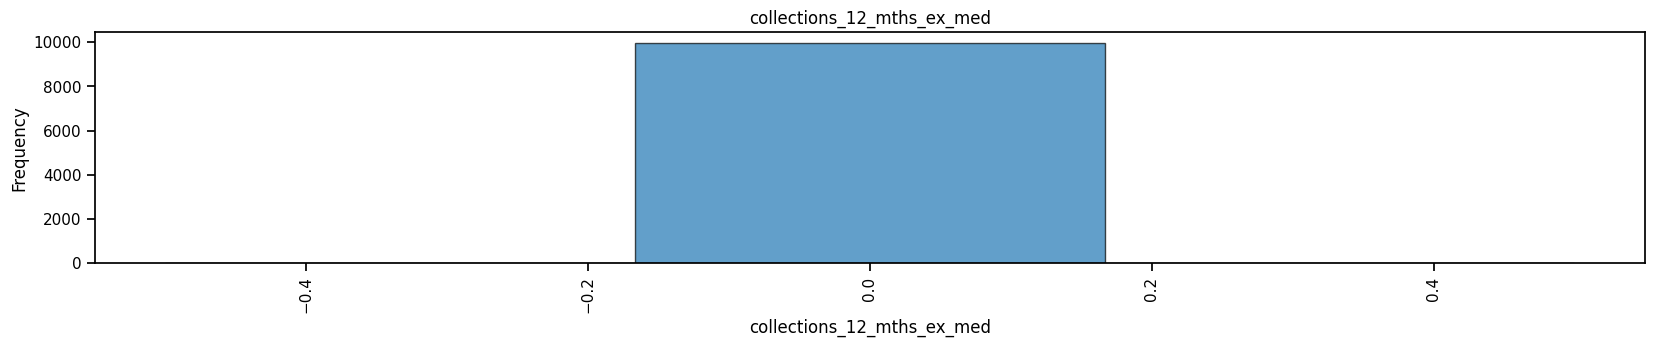

,column,dtype,missing_rate%,unique_count,min_value,max_value,dominant_value,dominant_share,variance,near_constant_flag,top_5_values
25,collections_12_mths_ex_med,Int64,0.320256,1,0.0,0.0,0,1.0,0.0,True,0:9960; NaN:32


In [43]:
inspect_column_pre_split("collections_12_mths_ex_med")

In [44]:
missing_imputation_cols.append("collections_12_mths_ex_med")
good2go_pre.append("collections_12_mths_ex_med")

#### debt_from_d2i_and_annual_inc - used for maximizing profit calculation; will be dropped

In [45]:
x_feature_drop_cols.append("debt_from_d2i_and_annual_inc")

#### debt_from_revols - used for maximizing profit calculation; will be dropped

In [46]:
x_feature_drop_cols.append("debt_from_revols")

#### debt_to_income - has 2 strong correlations

Data Type: Ratio


Column debt_to_income has strong correlation pairs:


,Feature1,Feature2,Correlation
4,debt_to_income,debt_from_d2i_and_annual_inc,0.558095
15,debt_to_income,open_acc,0.300972


Column debt_to_income has rare categories with counts less than 10:


debt_to_income
13.49    9
19.86    9
12.82    9
8.16     9
12.84    9
        ..
29.99    1
2.54     1
3.48     1
25.48    1
24.13    1
Name: count, Length: 2545, dtype: int64

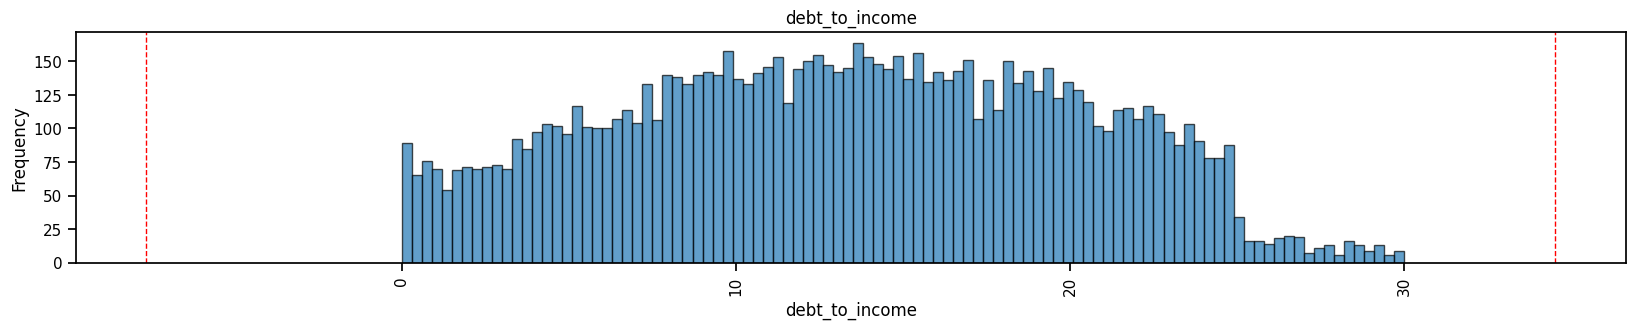

,column,dtype,missing_rate%,unique_count,min_value,max_value,dominant_value,dominant_share,variance,near_constant_flag,top_5_values
13,debt_to_income,float64,0.0,2584,0.0,29.99,0.0,0.005805,45.636269,False,0.0:58; 12.48:16; 18.14:13; 19.2:13; 13.51:13


In [47]:
inspect_column_pre_split("debt_to_income")

debt_from_d2i_and_annual_inc is for maximizing profit calculations and will be dropped

open_acc will be noted for it's correlation but kept for now

In [48]:
valid_correlations["debt_to_income"] = ["open_acc"]
good2go_pre.append("debt_to_income")

#### delinq_2yrs - added to median imputation, 1 negative correlation

Data Type: Discrete


Column delinq_2yrs has 5 missing values.
Column delinq_2yrs has strong correlation pairs:


,Feature1,Feature2,Correlation
16,delinq_2yrs,mths_since_last_delinq,-0.535391


Column delinq_2yrs has 1082 outlier rows based on IQR method (0 values below 0.0, 1082 values above 0.0).
Column delinq_2yrs has rare categories with counts less than 10:


delinq_2yrs
5     6
6     3
11    1
8     1
7     1
Name: count, dtype: Int64

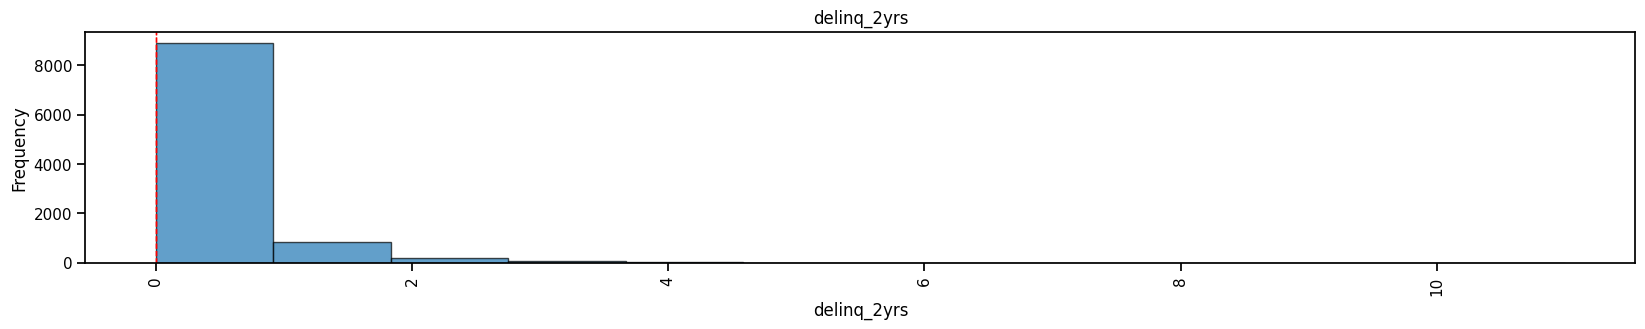

,column,dtype,missing_rate%,unique_count,min_value,max_value,dominant_value,dominant_share,variance,near_constant_flag,top_5_values
14,delinq_2yrs,Int64,0.05004,10,0.0,11.0,0,0.891659,0.251385,False,0:8905; 1:821; 2:185; 3:50; 4:14


In [49]:
inspect_column_pre_split("delinq_2yrs")

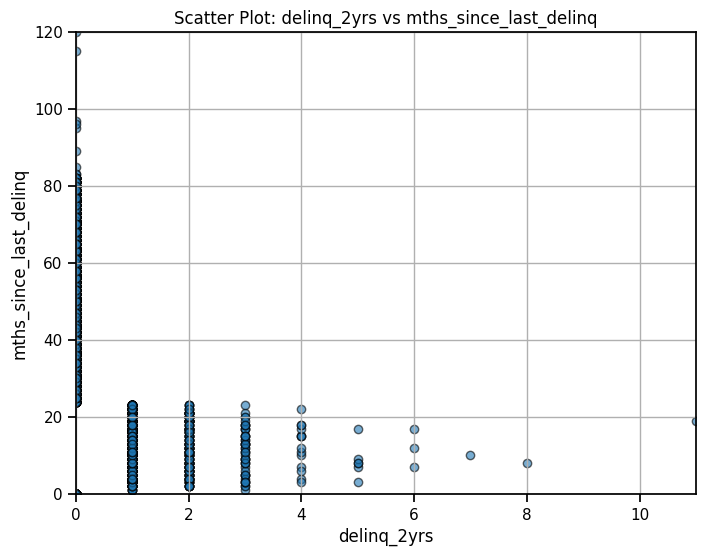

In [50]:
scatter_plot(df_clean, "delinq_2yrs", "mths_since_last_delinq", xlim=(0, df_clean["delinq_2yrs"].max()), ylim=(0, df_clean["mths_since_last_delinq"].max()))

In [51]:
valid_correlations["delinq_2yrs"] = ["mths_since_last_delinq"]
median_imputation_cols.append("delinq_2yrs")
good2go_pre.append("delinq_2yrs")

#### earliest_cr_line - added to median imputation, 1 strong correlation

Data Type: Date


Column earliest_cr_line has 5 missing values.
Column earliest_cr_line has strong correlation pairs:


,Feature1,Feature2,Correlation
10,total_acc,earliest_cr_line,0.400314


Column earliest_cr_line has 474 outlier rows based on IQR method (0 values below -3.5, 474 values above 24.5).
Column earliest_cr_line has rare categories with counts less than 10:


earliest_cr_line
41    7
40    6
46    2
43    2
44    2
45    2
42    1
57    1
49    1
52    1
Name: count, dtype: Int64

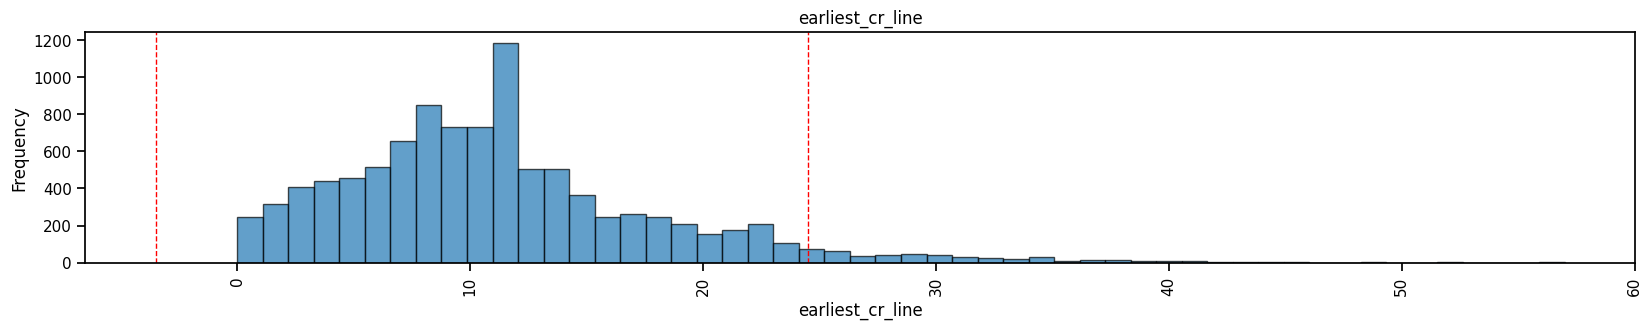

,column,dtype,missing_rate%,unique_count,min_value,max_value,dominant_value,dominant_share,variance,near_constant_flag,top_5_values
15,earliest_cr_line,Int64,0.05004,50,0.0,57.0,8,0.085011,46.666642,False,8:849; 10:730; 9:729; 7:656; 11:596


In [52]:
inspect_column_pre_split("earliest_cr_line")

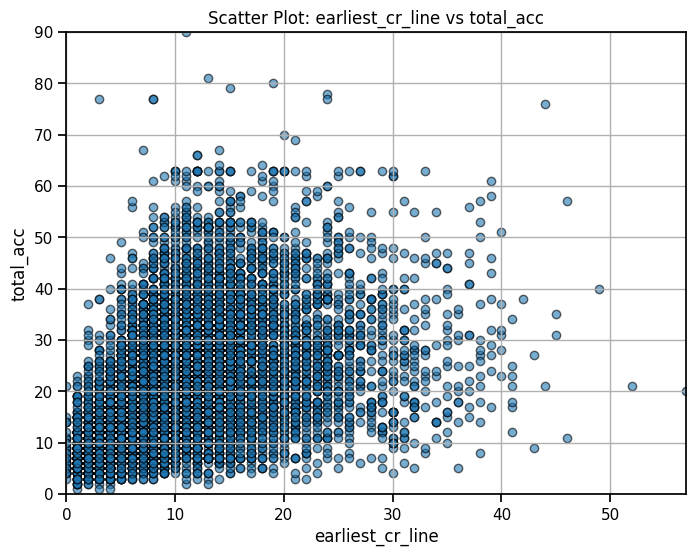

In [53]:
scatter_plot(df_clean, "earliest_cr_line", "total_acc", xlim=(0, df_clean["earliest_cr_line"].max()), ylim=(0, df_clean["total_acc"].max()))

In [54]:
valid_correlations["earliest_cr_line"] = ["total_acc"]
median_imputation_cols.append("earliest_cr_line")
good2go_pre.append("earliest_cr_line")

#### emp_length - added to missing imputation

Data Type: Ordinal


Column emp_length has 250 missing values.


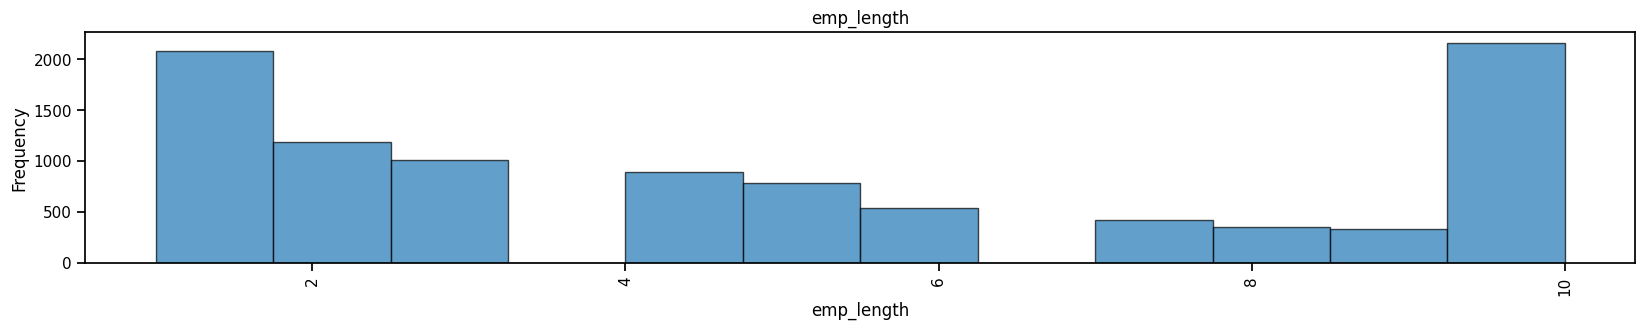

,column,dtype,missing_rate%,unique_count,min_value,max_value,dominant_value,dominant_share,variance,near_constant_flag,top_5_values
3,emp_length,Int64,2.502002,10,1.0,10.0,10,0.22172,11.659202,False,10:2160; 1:2083; 2:1183; 3:1010; 4:889


In [55]:
inspect_column_pre_split("emp_length")

In [56]:
missing_imputation_cols.append("emp_length")
good2go_pre.append("emp_length")

#### emp_title - 


If time, will work with NLP magic, but dropping for now

In [57]:
#takes a long time to run
# inspect_column_pre_split("emp_title")

In [58]:
x_feature_drop_cols.append("emp_title")

#### home_ownership - has a single value of "NONE" that will be changed to "OTHER"

Data Type: Nominal


Column home_ownership has rare categories with counts less than 10:


home_ownership
NONE    1
Name: count, dtype: int64

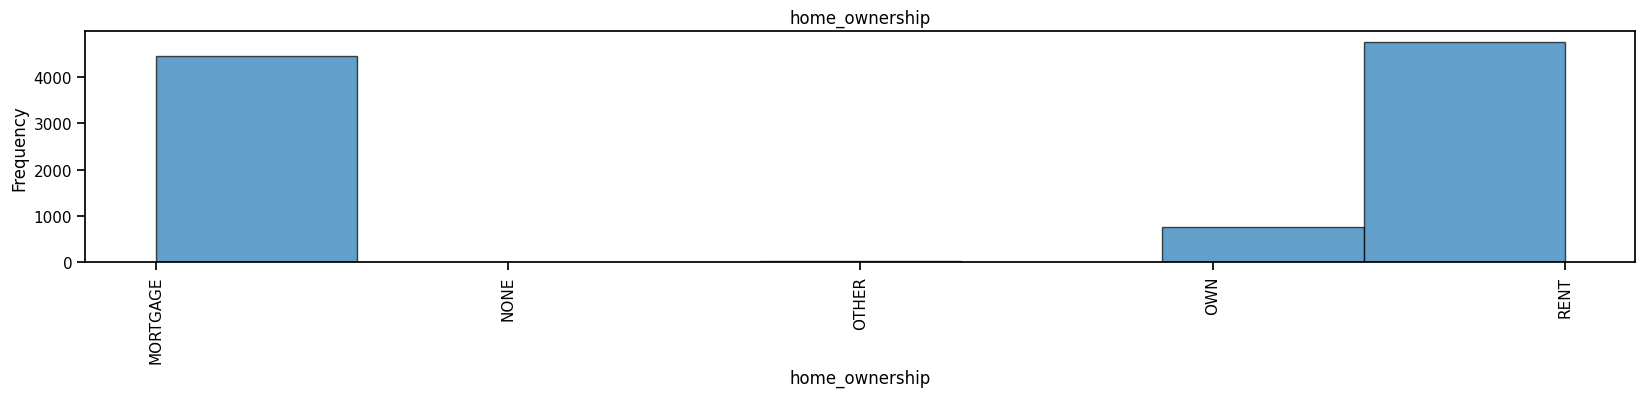

,column,dtype,missing_rate%,unique_count,dominant_value,dominant_share,near_constant_flag,top_5_values
4,home_ownership,object,0.0,5,RENT,0.47448,False,RENT:4741; MORTGAGE:4443; OWN:773; OTHER:34; N...


In [59]:
inspect_column_pre_split("home_ownership")

In [60]:
print(df_clean['home_ownership'].value_counts())

mapping = {
    "NONE": "OTHER"    
}
df_clean['home_ownership'] = df_clean['home_ownership'].replace(mapping)

print()
print(df_clean['home_ownership'].value_counts())

home_ownership
RENT        4741
MORTGAGE    4443
OWN          773
OTHER         34
NONE           1
Name: count, dtype: int64

home_ownership
RENT        4741
MORTGAGE    4443
OWN          773
OTHER         35
Name: count, dtype: int64


In [61]:
good2go_pre.append("home_ownership")

##### initial_list_status - has a minority category with only 17 categories; will be dealt with post-split after more analysis

Data Type: Nominal


Column initial_list_status is near-constant with dominant value f covering 99.83% of non-null values.


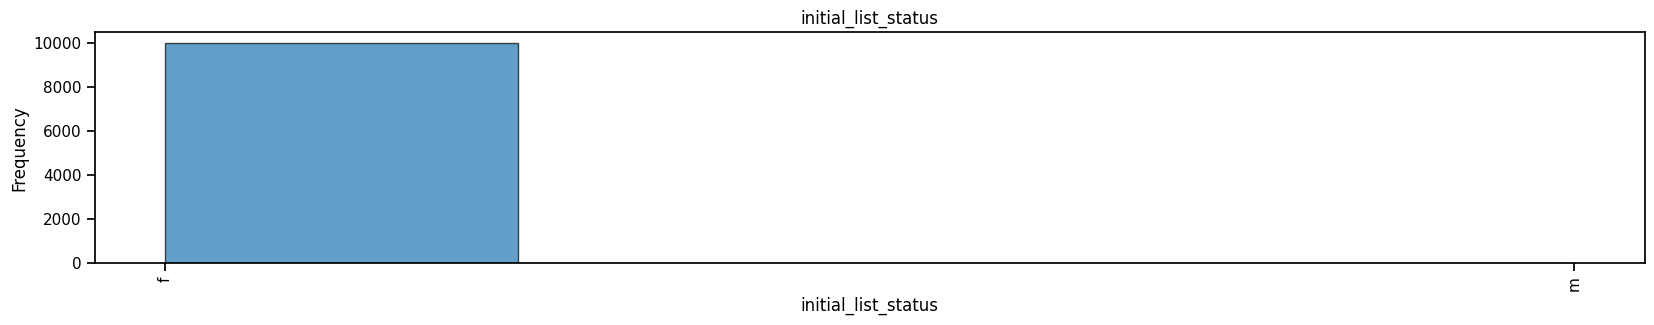

,column,dtype,missing_rate%,unique_count,dominant_value,dominant_share,near_constant_flag,top_5_values
24,initial_list_status,object,0.0,2,f,0.998299,True,f:9975; m:17


In [62]:
inspect_column_pre_split("initial_list_status")

In [63]:
good2go_pre.append("initial_list_status")

#### inq_last_6mths - missing values, outliers because of rare category values, minority categores will be dealt with post-split

Data Type: Discrete


Column inq_last_6mths has 5 missing values.
Column inq_last_6mths has 168 outlier rows based on IQR method (0 values below -3.0, 168 values above 5.0).
Column inq_last_6mths has rare categories with counts less than 10:


inq_last_6mths
18    2
10    2
11    2
16    1
25    1
17    1
15    1
24    1
14    1
12    1
Name: count, dtype: Int64

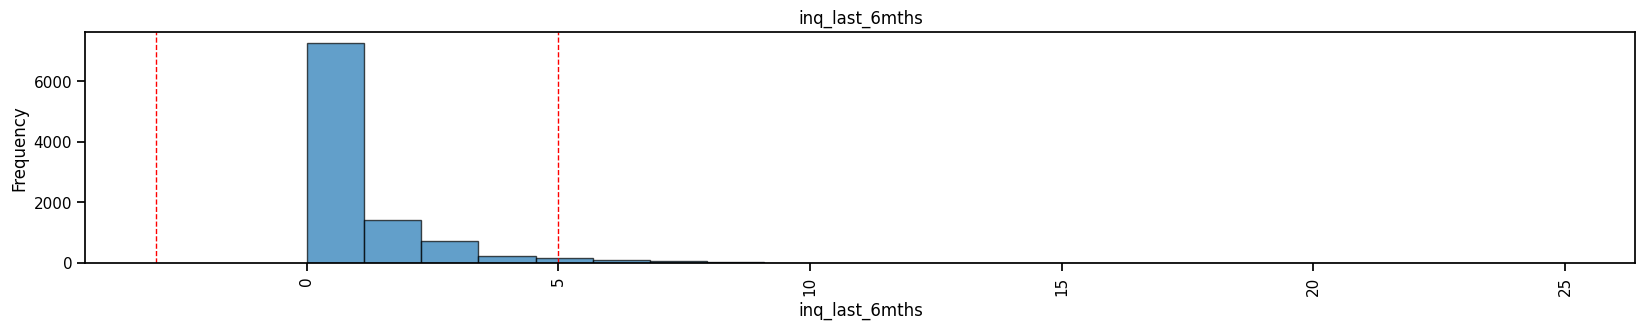

,column,dtype,missing_rate%,unique_count,min_value,max_value,dominant_value,dominant_share,variance,near_constant_flag,top_5_values
16,inq_last_6mths,Int64,0.05004,20,0.0,25.0,0,0.460799,2.180124,False,0:4602; 1:2680; 2:1427; 3:731; 4:227


In [64]:
inspect_column_pre_split("inq_last_6mths")

In [65]:
median_imputation_cols.append("inq_last_6mths")
good2go_pre.append("inq_last_6mths")

#### is_bad is target value; added to drop list but action is redundant

In [66]:
x_feature_drop_cols.append("is_bad")

#### mths_since_last_delinq - added to missing imputation

Data Type: Discrete


Column mths_since_last_delinq has 6311 missing values.
Column mths_since_last_delinq has strong correlation pairs:


,Feature1,Feature2,Correlation
7,mths_since_last_delinq,mths_since_last_record,0.465476
16,delinq_2yrs,mths_since_last_delinq,-0.535391


Column mths_since_last_delinq has 2 outlier rows based on IQR method (0 values below -34.5, 2 values above 105.5).
Column mths_since_last_delinq has rare categories with counts less than 10:


mths_since_last_delinq
1      6
83     2
115    1
97     1
95     1
85     1
120    1
89     1
96     1
Name: count, dtype: Int64

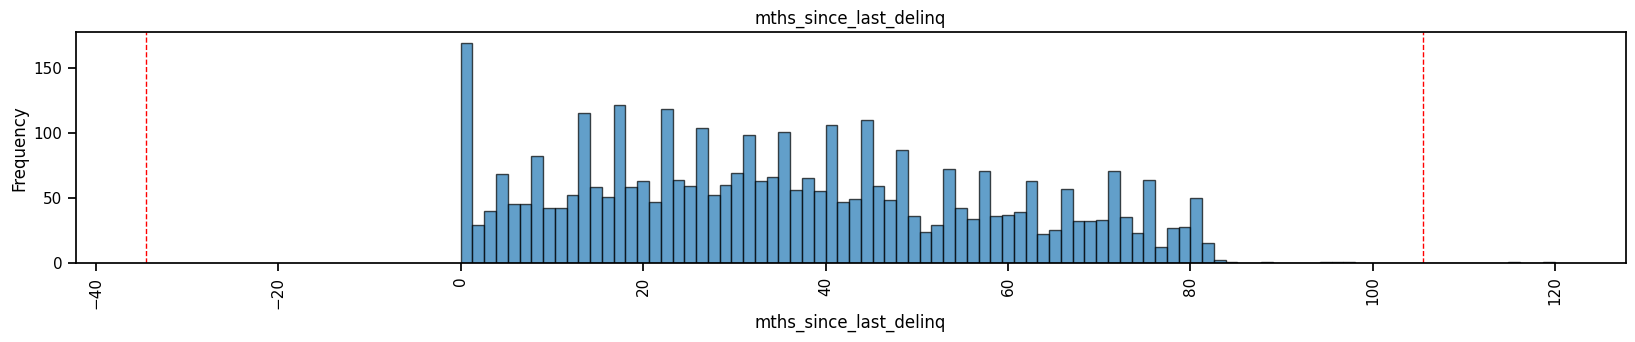

,column,dtype,missing_rate%,unique_count,min_value,max_value,dominant_value,dominant_share,variance,near_constant_flag,top_5_values
17,mths_since_last_delinq,Int64,63.160528,91,0.0,120.0,0,0.044281,500.148992,False,NaN:6311; 0:163; 30:69; 34:66; 23:65


In [67]:
inspect_column_pre_split("mths_since_last_delinq")

In [68]:
missing_imputation_cols.append("mths_since_last_delinq")
good2go_pre.append("mths_since_last_delinq")

#### mths_since_last_major_derog - other than column appearing to be misnamed, everything looks good

Data Type: Nominal


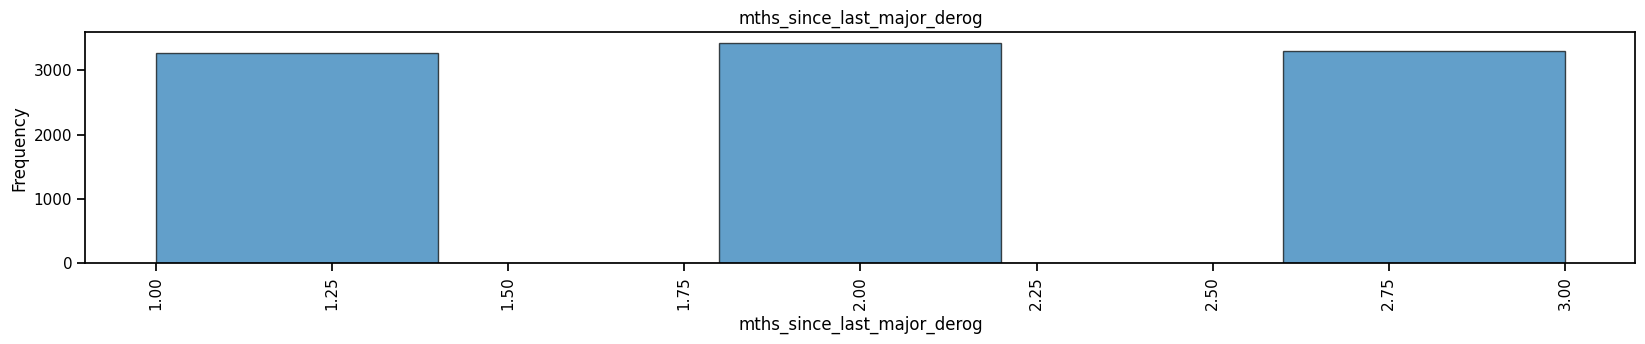

,column,dtype,missing_rate%,unique_count,min_value,max_value,dominant_value,dominant_share,variance,near_constant_flag,top_5_values
26,mths_since_last_major_derog,Int64,0.0,3,1.0,3.0,2,0.342474,0.657586,False,2:3422; 3:3297; 1:3273


In [69]:
inspect_column_pre_split("mths_since_last_major_derog")

In [70]:
good2go_pre.append("mths_since_last_major_derog")

#### mths_since_last_record - added to missing imputation, pub_rec correlation is because pub_rec has very few categories; mths_since_last_delinq correlation is valid

Data Type: Discrete


Column mths_since_last_record has 9153 missing values.
Column mths_since_last_record has strong correlation pairs:


,Feature1,Feature2,Correlation
1,mths_since_last_record,pub_rec,0.783968
7,mths_since_last_delinq,mths_since_last_record,0.465476


Column mths_since_last_record has rare categories with counts less than 10:


mths_since_last_record
97     9
90     9
112    9
102    8
103    7
      ..
47     1
41     1
59     1
68     1
24     1
Name: count, Length: 64, dtype: Int64

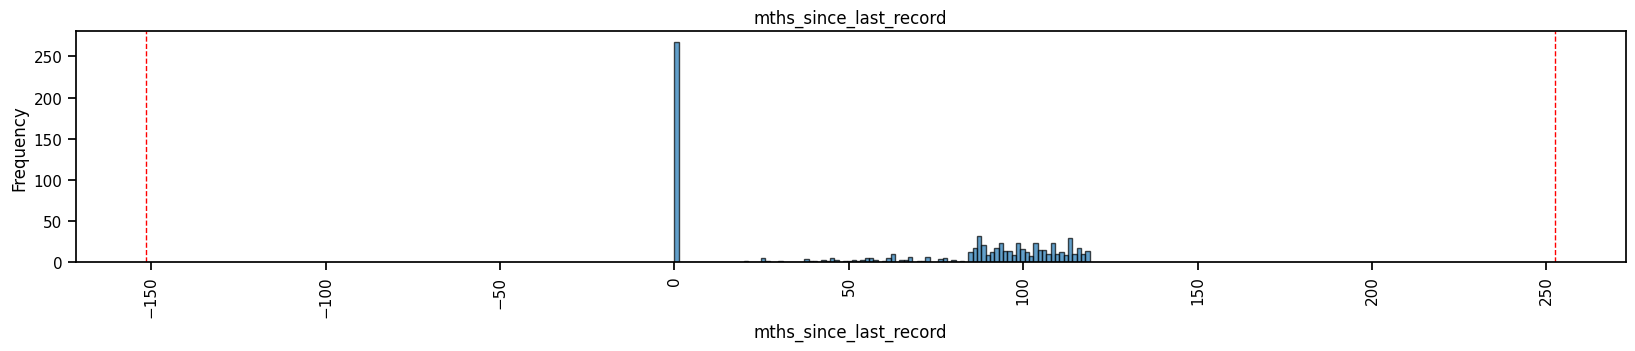

,column,dtype,missing_rate%,unique_count,min_value,max_value,dominant_value,dominant_share,variance,near_constant_flag,top_5_values
18,mths_since_last_record,Int64,91.603283,94,0.0,119.0,0,0.318236,2134.776706,False,NaN:9153; 0:267; 89:21; 116:18; 86:17


In [71]:
inspect_column_pre_split("mths_since_last_record")

In [72]:
print(get_col_description("mths_since_last_record"))
print(get_col_description("pub_rec"))

Months since the borrower’s last public record
Number of derogatory public records (e.g., bankruptcies, judgments)


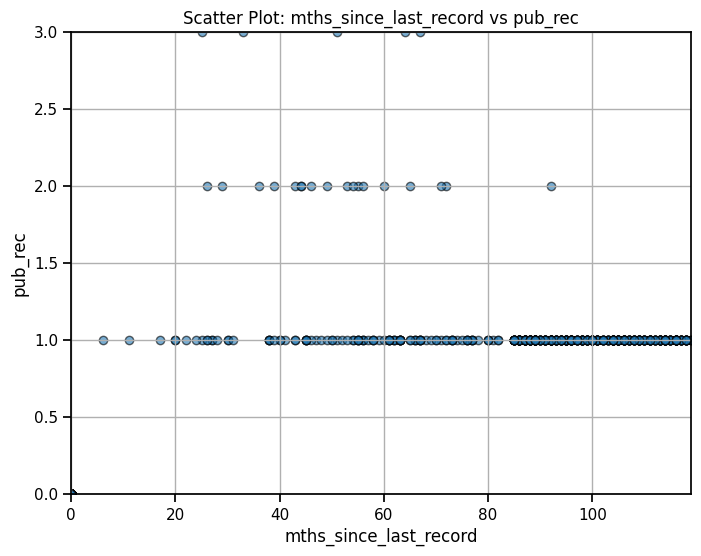

In [73]:
scatter_plot(df_clean, "mths_since_last_record", "pub_rec", xlim=(0, df_clean["mths_since_last_record"].max()), ylim=(0, df_clean["pub_rec"].max()))

In [74]:
valid_correlations["mths_since_last_record"] = ["mths_since_last_delinq"]
missing_imputation_cols.append("mths_since_last_record")
good2go_pre.append("mths_since_last_record")

#### open_acc - added to median imputation, should some correlation to debt_to_income which makes sense; strong correlation to open_acc - consider creating column closed_acc that might signal ability to repay

Data Type: Discrete


Column open_acc has 5 missing values.
Column open_acc has strong correlation pairs:


,Feature1,Feature2,Correlation
2,open_acc,total_acc,0.695341
9,open_acc,debt_from_d2i_and_annual_inc,0.428138
15,debt_to_income,open_acc,0.300972


Column open_acc has 157 outlier rows based on IQR method (0 values below -3.0, 157 values above 21.0).
Column open_acc has rare categories with counts less than 10:


open_acc
26    8
27    8
1     7
30    6
28    6
29    6
33    3
31    3
36    2
39    1
35    1
32    1
Name: count, dtype: Int64

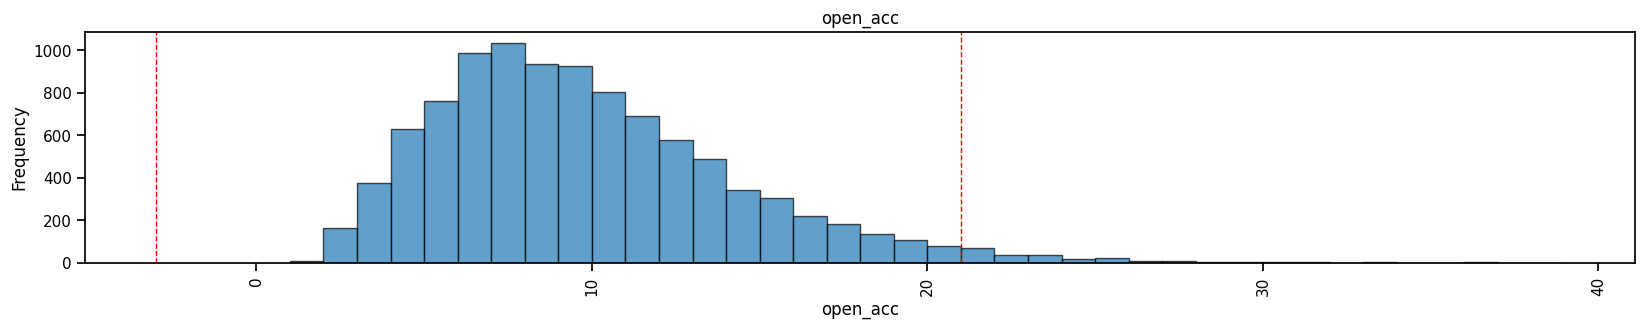

,column,dtype,missing_rate%,unique_count,min_value,max_value,dominant_value,dominant_share,variance,near_constant_flag,top_5_values
19,open_acc,Int64,0.05004,36,1.0,39.0,7,0.103635,20.501298,False,7:1035; 6:988; 8:937; 9:926; 10:805


In [75]:
inspect_column_pre_split("open_acc")

In [76]:
print(get_col_description("open_acc"))
print(get_col_description("total_acc"))

Number of currently open credit accounts
Total number of credit accounts


In [77]:
valid_correlations["open_acc"] = ["total_acc", "debt_from_d2i_and_annual_inc", "debt_to_income"]
median_imputation_cols.append("open_acc")
good2go_pre.append("open_acc")

#### policy_code

Data Type: Nominal


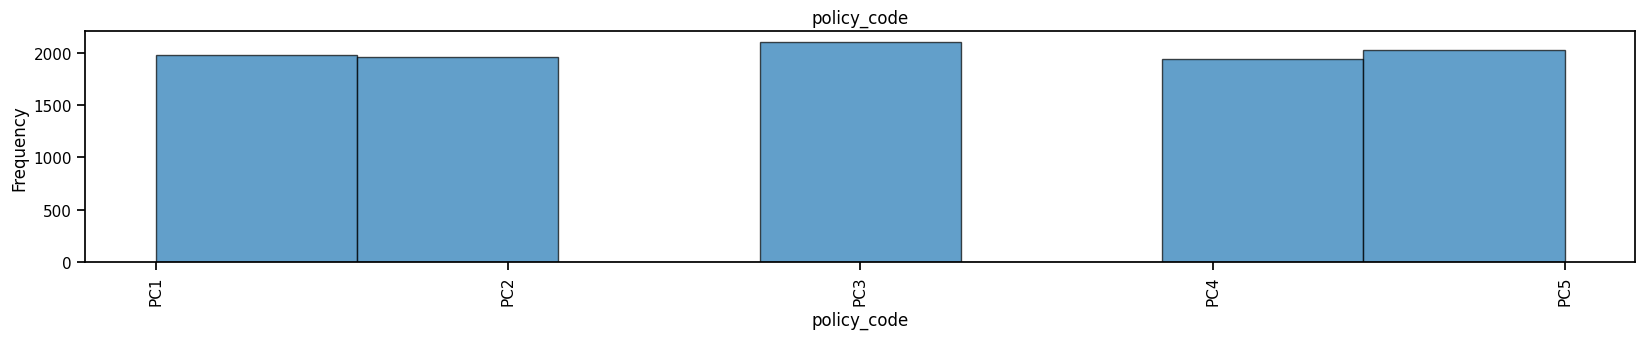

,column,dtype,missing_rate%,unique_count,dominant_value,dominant_share,near_constant_flag,top_5_values
27,policy_code,object,0.0,5,PC3,0.209868,False,PC3:2097; PC5:2022; PC1:1976; PC2:1961; PC4:1936


In [78]:
inspect_column_pre_split("policy_code")

In [79]:
good2go_pre.append("policy_code")

#### pub_rec

Data Type: Discrete


Column pub_rec has 5 missing values.
Column pub_rec has strong correlation pairs:


,Feature1,Feature2,Correlation
1,mths_since_last_record,pub_rec,0.783968


Column pub_rec has 572 outlier rows based on IQR method (0 values below 0.0, 572 values above 0.0).
Column pub_rec has rare categories with counts less than 10:


pub_rec
3    5
Name: count, dtype: Int64

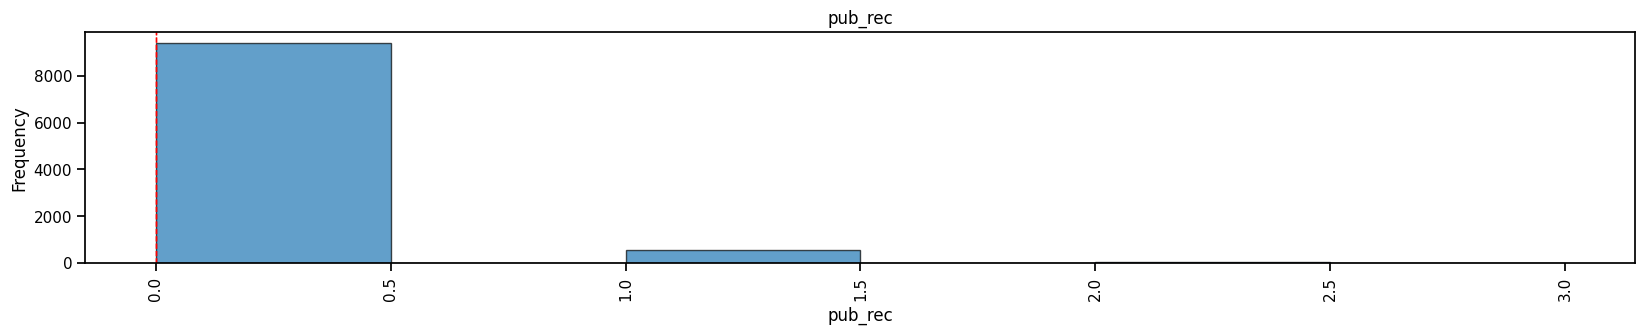

,column,dtype,missing_rate%,unique_count,min_value,max_value,dominant_value,dominant_share,variance,near_constant_flag,top_5_values
20,pub_rec,Int64,0.05004,4,0.0,3.0,0,0.942726,0.063084,False,0:9415; 1:549; 2:18; 3:5; NaN:5


In [80]:
inspect_column_pre_split("pub_rec")

In [81]:
missing_imputation_cols.append("pub_rec")
good2go_pre.append("pub_rec")

#### purpose - If time, will work with NLP magic, but dropping for now

In [82]:
x_feature_drop_cols.append("purpose")

#### purpose_cat

Data Type: Nominal


Column purpose_cat has rare categories with counts less than 10:


purpose_cat
major purchase small business    5
educational small business       5
house small business             3
moving small business            3
car small business               3
wedding small business           2
medical small business           2
vacation small business          2
Name: count, dtype: int64

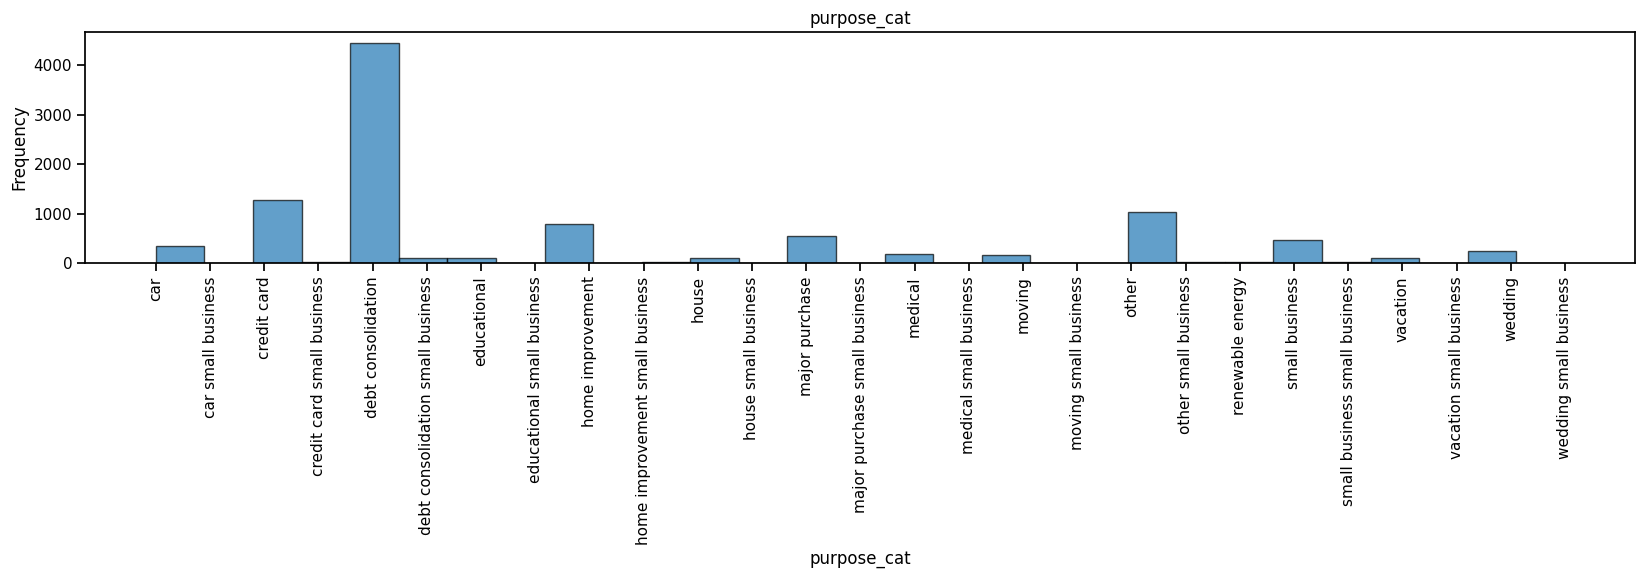

,column,dtype,missing_rate%,unique_count,dominant_value,dominant_share,near_constant_flag,top_5_values
9,purpose_cat,object,0.0,27,debt consolidation,0.445757,False,debt consolidation:4454; credit card:1273; oth...


In [83]:
inspect_column_pre_split("purpose_cat")

In [84]:
good2go_pre.append("purpose_cat")

#### pymnt_plan

Data Type: Nominal


Column pymnt_plan is near-constant with dominant value n covering 99.98% of non-null values.
Column pymnt_plan has rare categories with counts less than 10:


pymnt_plan
y    2
Name: count, dtype: int64

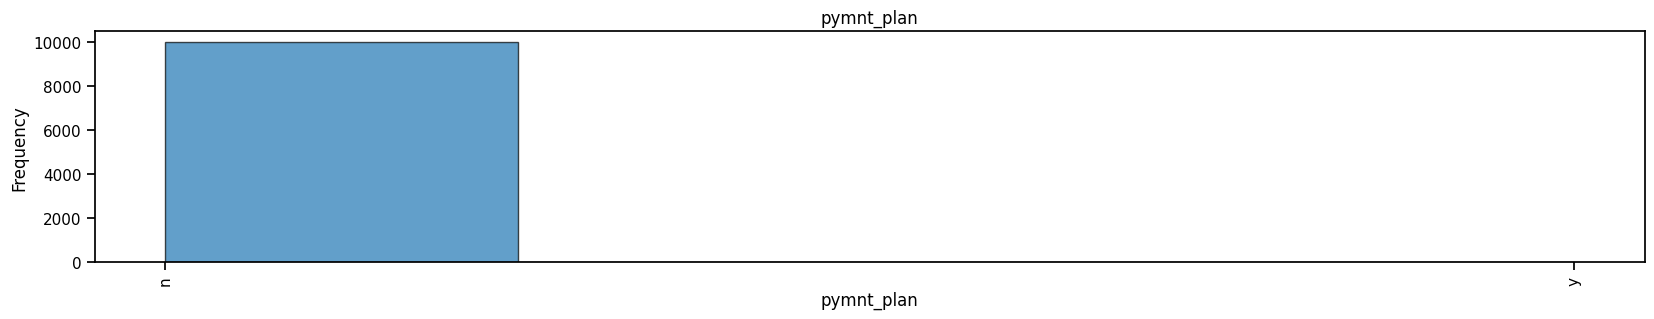

,column,dtype,missing_rate%,unique_count,dominant_value,dominant_share,near_constant_flag,top_5_values
7,pymnt_plan,object,0.0,2,n,0.9998,True,n:9990; y:2


In [85]:
inspect_column_pre_split("pymnt_plan")

In [86]:
x_feature_drop_cols.append("pymnt_plan")

#### revol_bal

Data Type: Ratio


Column revol_bal has strong correlation pairs:


,Feature1,Feature2,Correlation
0,revol_bal,debt_from_revols,0.891118
6,revol_bal,debt_from_d2i_and_annual_inc,0.473496
12,annual_inc,revol_bal,0.359756


Column revol_bal has 699 outlier rows based on IQR method (0 values below -16615.875, 699 values above 37095.125).
Column revol_bal has rare categories with counts less than 10:


revol_bal
1763     6
2227     6
760      5
11628    5
4801     5
        ..
26482    1
12893    1
8841     1
8230     1
2304     1
Name: count, Length: 8123, dtype: Int64

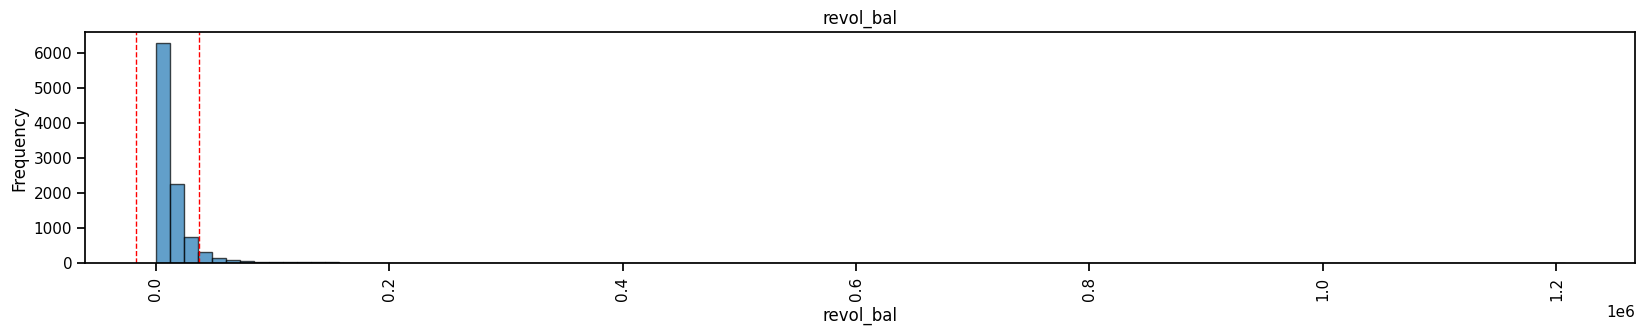

,column,dtype,missing_rate%,unique_count,min_value,max_value,dominant_value,dominant_share,variance,near_constant_flag,top_5_values
21,revol_bal,Int64,0.0,8124,0.0,1207359.0,0,0.027822,6.474564e+08,False,0:278; 1763:6; 2227:6; 760:5; 11628:5


In [87]:
inspect_column_pre_split("revol_bal")

In [88]:
df_clean["revol_bal"].nlargest(10)

159     1207359
4695     602519
2835     508961
5480     487589
7453     423189
9769     401941
1097     394107
9351     388892
4182     290291
5445     276911
Name: revol_bal, dtype: Int64

In [89]:
x_feature_drop_cols.append("revol_bal")

#### revol_util

Data Type: Ratio


Column revol_util has 26 missing values.
Column revol_util has strong correlation pairs:


,Feature1,Feature2,Correlation
11,revol_util,debt_from_revols,0.371486


Column revol_util has rare categories with counts less than 10:


revol_util
6.00      9
22.70     9
62.60     9
85.30     9
74.70     9
         ..
100.00    1
47.36     1
62.31     1
10.00     1
100.60    1
Name: count, Length: 529, dtype: int64

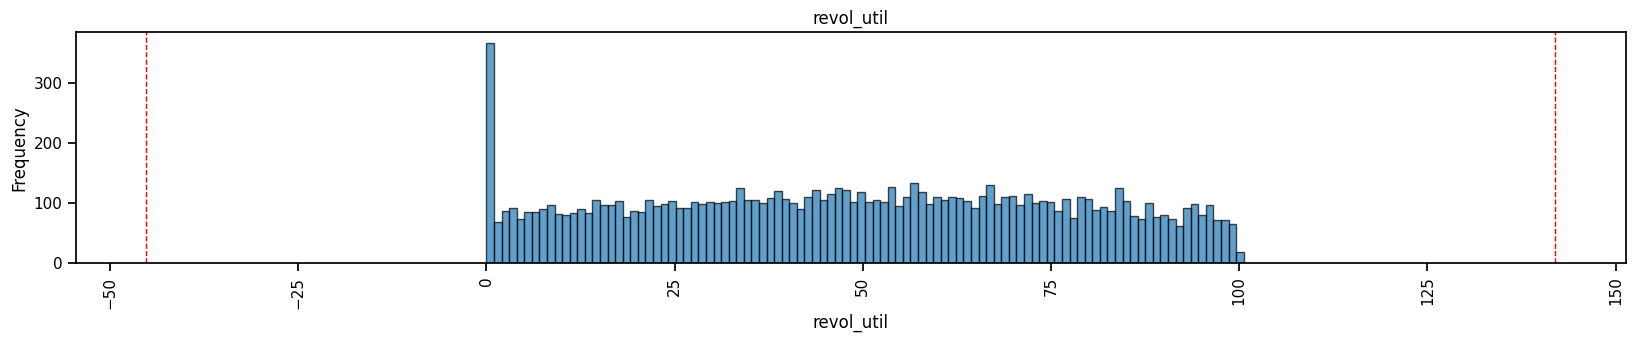

,column,dtype,missing_rate%,unique_count,min_value,max_value,dominant_value,dominant_share,variance,near_constant_flag,top_5_values
22,revol_util,float64,0.260208,1027,0.0,100.6,0.0,0.025386,796.000434,False,0.0:253; NaN:26; 46.6:21; 43.4:20; 0.1:20


In [90]:
inspect_column_pre_split("revol_util")

In [91]:
median_imputation_cols.append("revol_util")
good2go_pre.append("revol_util")

#### total_acc

Data Type: Discrete


Column total_acc has 5 missing values.
Column total_acc has strong correlation pairs:


,Feature1,Feature2,Correlation
2,open_acc,total_acc,0.695341
8,total_acc,debt_from_d2i_and_annual_inc,0.454371
10,total_acc,earliest_cr_line,0.400314
13,annual_inc,total_acc,0.329061


Column total_acc has 137 outlier rows based on IQR method (0 values below -11.0, 137 values above 53.0).
Column total_acc has rare categories with counts less than 10:


total_acc
60    9
62    8
61    7
59    7
58    5
77    4
1     3
64    2
67    2
66    2
69    1
79    1
70    1
90    1
80    1
76    1
78    1
81    1
Name: count, dtype: Int64

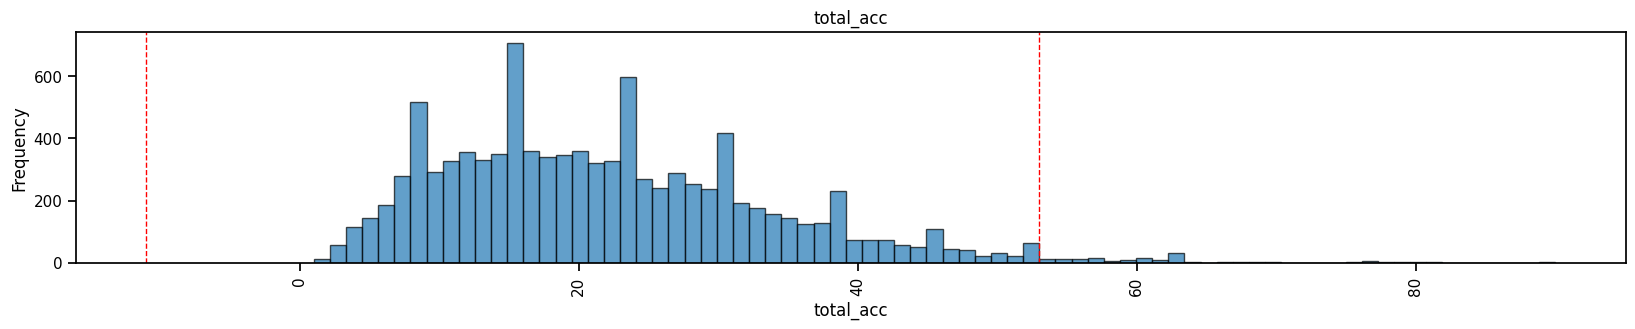

,column,dtype,missing_rate%,unique_count,min_value,max_value,dominant_value,dominant_share,variance,near_constant_flag,top_5_values
23,total_acc,Int64,0.05004,75,1.0,90.0,15,0.036948,137.13117,False,15:369; 20:360; 17:360; 12:356; 14:351


In [92]:
inspect_column_pre_split("total_acc")

In [93]:
valid_correlations["total_acc"] = ["open_acc", "debt_from_d2i_and_annual_inc", "earliest_cr_line", "annual_inc"]
median_imputation_cols.append("total_acc")
good2go_pre.append("total_acc")

#### verification_status

Data Type: Nominal


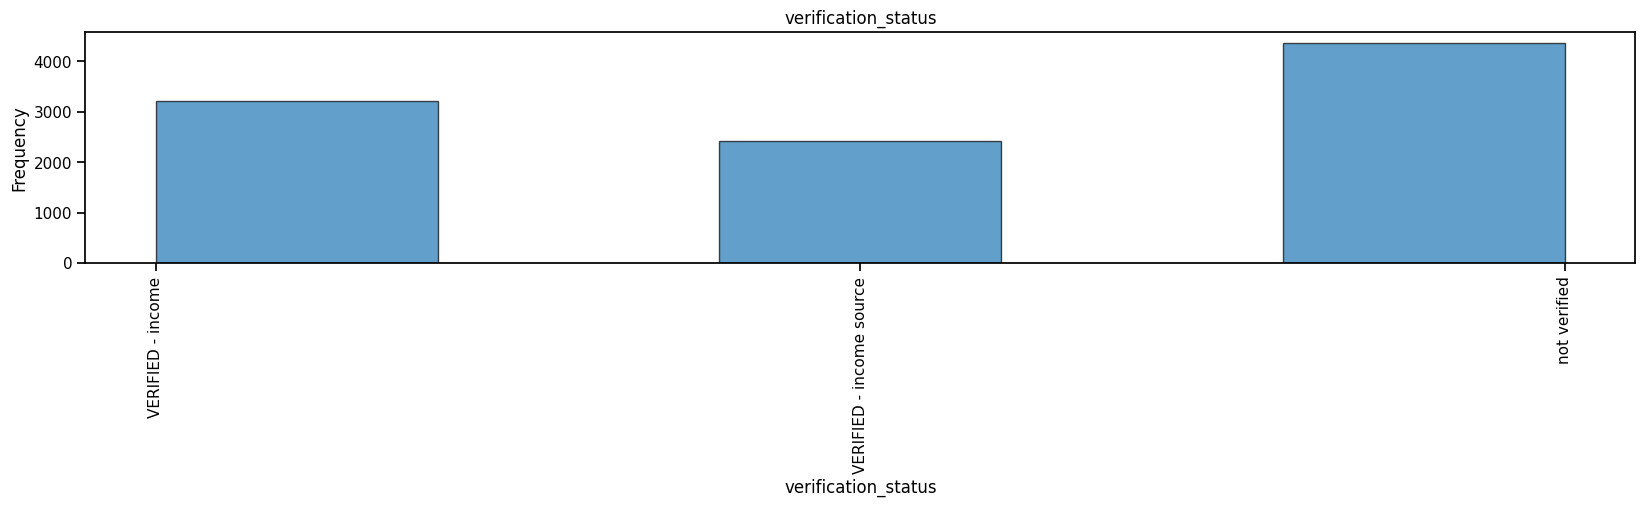

,column,dtype,missing_rate%,unique_count,dominant_value,dominant_share,near_constant_flag,top_5_values
6,verification_status,object,0.0,3,not verified,0.436749,False,not verified:4364; VERIFIED - income:3213; VER...


In [94]:
inspect_column_pre_split("verification_status")

In [95]:
good2go_pre.append("verification_status")

#### zip_code - too many unique values - will drop

Data Type: Nominal


Column zip_code has rare categories with counts less than 10:


zip_code
199xx    9
144xx    9
918xx    9
658xx    9
905xx    9
        ..
654xx    1
749xx    1
831xx    1
037xx    1
637xx    1
Name: count, Length: 434, dtype: int64

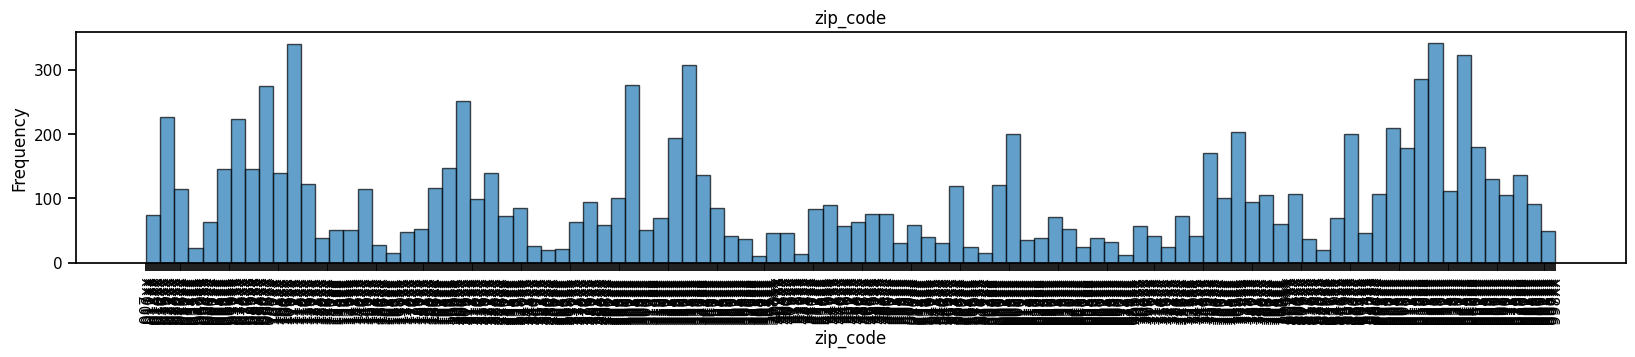

,column,dtype,missing_rate%,unique_count,dominant_value,dominant_share,near_constant_flag,top_5_values
11,zip_code,object,0.0,720,100xx,0.015813,False,100xx:158; 112xx:140; 945xx:129; 070xx:125; 60...


In [96]:
inspect_column_pre_split("zip_code")

In [97]:
x_feature_drop_cols.append("zip_code")

# Splitting the dataset

In [98]:
target_col = 'is_bad'
X = df_clean.drop(columns=[target_col]).copy()
y = df_clean[target_col].copy()

# First: split off the test set (10%)
X_temp, X_test, y_temp, y_test = train_test_split(
# X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.10,
    stratify=y,
    random_state=42
)

# Next: split the remaining 90% into train (80%) and validation (10%)
# Since test already took 10%, we want 10/90 = ~0.1111 of the remainder as validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=1/9,   # ≈ 0.1111
    stratify=y_temp,
    random_state=42
)

splits = [X_train, X_val, X_test, y_train, y_val, y_test]

print(f"Training set shape: {X_train.shape}, {y_train.shape}, {y_train.sum()/y_train.shape[0]} positive samples")
print(f"Validation set shape: {X_val.shape}, {y_val.shape}, {y_val.sum()/y_val.shape[0]} positive samples")
print(f"Test set shape: {X_test.shape}, {y_test.shape}, {y_test.sum()/y_test.shape[0]} positive samples")

Training set shape: (7992, 29), (7992,), 0.12875375375375375 positive samples
Validation set shape: (1000, 29), (1000,), 0.129 positive samples
Test set shape: (1000, 29), (1000,), 0.129 positive samples


# Inspect individual columns post-split

Drill down into if time allows

In [99]:
df_analysis = df_clean[df_clean['Id'].isin(X_train['Id'])]
assert df_analysis.shape[0] == X_train.shape[0]

# Decide Which Columns to Keep

In [100]:
use_cols = ["emp_length","home_ownership","annual_inc","debt_to_income","delinq_2yrs","earliest_cr_line","open_acc","pub_rec"]

# Impute Columns

In [101]:
for col in use_cols:

    #missing imputation
    if col in missing_imputation_cols:
        df_analysis[col] = df_analysis[col].fillna(-1)
        for split in splits:
            if col in split:
                split[col] = split[col].fillna(-1)

    #median imputation
    if col in median_imputation_cols:
        median = X_train[col].median()
        df_analysis[col] = df_analysis[col].fillna(median)
        for split in splits:
            if col in split:
                split[col] = split[col].fillna(median)

x_sets = [X_train, X_val, X_test]
for x_set in x_sets:
    # Drop columns not in use_cols
    cols_to_drop = [col for col in x_set.columns if col not in use_cols]
    x_set.drop(columns=cols_to_drop, inplace=True)

# Final Processing

In [102]:
# Preprocess: median impute numerics; impute + encode categoricals (example)
# numeric_preprocess = SimpleImputer(strategy="median")
categorical_preprocess = Pipeline(steps=[
    # ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        # ("num", numeric_preprocess, [x for x in median_imputation_cols if x in X_train.columns]),
        ("cat", categorical_preprocess, [x for x in missing_imputation_cols if x in X_train.columns]),
    ]
)

# Oversampling of positive minority class
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [103]:
def calculate_profit_saved(df: pd.DataFrame, interest_rate = 0.05):
    
    df["revenue"] = 0
    df["revenue"] = np.where(df["is_bad"] == 0, df["debt_from_revols"]*interest_rate, df["debt_from_revols"]*-1)
    revenue_total_wo = df["revenue"].sum()
    print(f"Total revenue on dataset without model: ${revenue_total_wo:,.2f}")
    revenue_total_with = df[df["pred"] == 0]["revenue"].sum()
    print(f"Total revenue on dataset with model: ${revenue_total_with:,.2f}")
    print(f"Total savings in revenue from model: ${-(revenue_total_wo - revenue_total_with):,.2f}")
    print(f"Total % savings in revenue from model: {((revenue_total_wo - revenue_total_with)/revenue_total_wo*100):,.2f}%")


# Logistic Regression

In [104]:
# # - saga handles l1/l2 with large/sparse OHE
# # - class_weight="balanced" helps with modest imbalance
logreg = LogisticRegression(
    solver="saga",
    penalty="l2",
    max_iter=5000,
    n_jobs=-1,
    class_weight="balanced",  # remove if your classes are already balanced
    random_state=42
)

# End-to-end pipeline (preprocess → model)
clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", logreg)
])

clf.fit(X_resampled, y_resampled)
print("Train set accuracy:", clf.score(X_train, y_train))
print("Validation set  accuracy:", clf.score(X_val, y_val))

x_out = X_val.copy()
x_out = x_out.merge(df_clean[["debt_from_revols"]], left_index=True, right_index=True)
x_out["pred"] = clf.predict(X_val)
x_out["is_bad"] = y_val
x_out["correct"] = np.where(x_out["pred"] == x_out["is_bad"], 1, 0)
calculate_profit_saved(x_out)

Train set accuracy: 0.5948448448448449
Validation set  accuracy: 0.61
Total revenue on dataset without model: $-757,725.97
Total revenue on dataset with model: $-441,329.99
Total savings in revenue from model: $316,395.98
Total % savings in revenue from model: 41.76%


# Random Forest

In [105]:
# End-to-end pipeline (preprocess → model)
clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=200,
        max_depth=None, 
        random_state=42,
        n_jobs=-1
    ))
])

clf.fit(X_resampled, y_resampled)
print("Train accuracy:", clf.score(X_resampled, y_resampled))
print("Test  accuracy:", clf.score(X_test, y_test))

x_out = X_val.copy()
x_out = x_out.merge(df_clean[["debt_from_revols"]], left_index=True, right_index=True)
x_out["pred"] = clf.predict(X_val)
x_out["is_bad"] = y_val
x_out["correct"] = np.where(x_out["pred"] == x_out["is_bad"], 1, 0)
calculate_profit_saved(x_out)

Train accuracy: 0.5422949877926181
Test  accuracy: 0.568
Total revenue on dataset without model: $-757,725.97
Total revenue on dataset with model: $-435,372.76
Total savings in revenue from model: $322,353.21
Total % savings in revenue from model: 42.54%


In [ ]:
col = "delinq_2yrs"
display(X_train[col].value_counts(dropna=False))
histogram(df_analysis, col)

df_summary_col = df_summary[df_summary['column'] == col][summary_cols]
df_summary_col.dropna(inplace=True, axis=1)
display(df_summary_col)

col = "delinq_2yrs"
bins= col_bins[col]
labels=list(range(len(bins)-1))
labels = [chr(65 + i) for i in range(len(bins)-1)]

X_train[col] = pd.cut(X_train[col], bins=bins, labels=labels)
X_test[col] = pd.cut(X_test[col], bins=bins, labels=labels)

# Works on PowerBI

In [ ]:
# df_pbi = df_clean.copy()
df_pbi = df_analysis.copy()

drop_cols = ["Notes", "emp_title", "purpose_cat", "purpose"]
df_pbi.drop(columns=drop_cols, inplace=True)

mapping = {"RENT": "R", "MORTGAGE": "M", "OWN": "O", "OTHER": "X"}
df_pbi["home_ownership"] = df_pbi["home_ownership"].map(mapping)

mapping = {"Not Verified": "no", "Source Verified": "source", "Verified": "yes"}
df_pbi["verification_status"] = df_pbi["verification_status"].map(mapping)

mapping = {"PC1": "1","PC2": "2","PC3": "3","PC4": "4","PC5": "5"}
df_pbi["policy_code"] = df_pbi["policy_code"].map(mapping)
df_pbi["policy_code"] = df_pbi["policy_code"].astype("Int64")

df_pbi.to_csv("lending_club_dataset_for_powerbi.csv", index=False)


can_work = ["zip_code","mths_since_last_major_derog","policy_code"]
confirmed_bad = ["Notes","purpose"]

In [ ]:
# Regularization strength (C): smaller = stronger regularization
# Try both L1 and L2; L1 can yield sparsity with OHE features
param_grid = {
    "clf__penalty": ["l1", "l2"],
    "clf__C": [0.01, 0.1, 1.0, 3.0, 10.0]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="roc_auc",
    n_jobs=-1,
    cv=cv,
    refit=True,
    verbose=1
)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV ROC-AUC:", round(grid.best_score_, 4))
best_model = grid.best_estimator_

In [ ]:
# Predictions
y_prob = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

# Metrics
roc_auc = roc_auc_score(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)  # PR AUC
print(f"Test ROC-AUC: {roc_auc:.4f}")
print(f"Test Average Precision (PR AUC): {ap:.4f}\n")
print(classification_report(y_test, y_pred, digits=3))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
disp.plot(values_format="d")
plt.title("Confusion Matrix (threshold=0.5)")
plt.show()

# ROC curve
RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.title("ROC Curve")
plt.show()

# Precision-Recall curve
PrecisionRecallDisplay.from_estimator(best_model, X_test, y_test)
plt.title("Precision-Recall Curve")
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve, f1_score

prec, rec, th = precision_recall_curve(y_test, y_prob)
f1s = 2 * (prec * rec) / (prec + rec + 1e-12)
best_idx = np.nanargmax(f1s)
best_threshold = th[best_idx] if best_idx < len(th) else 0.5

print(f"Best threshold for F1 ≈ {best_threshold:.3f} with F1={f1s[best_idx]:.3f}")

# Evaluate with tuned threshold
y_pred_tuned = (y_prob >= best_threshold).astype(int)
print(classification_report(y_test, y_pred_tuned, digits=3))

cm2 = confusion_matrix(y_test, y_pred_tuned, labels=[0,1])
ConfusionMatrixDisplay(cm2, display_labels=[0,1]).plot(values_format="d")
plt.title(f"Confusion Matrix (threshold={best_threshold:.2f})")
plt.show()

In [ ]:
# Get feature names after preprocessing
ohe = best_model.named_steps["preprocess"].named_transformers_["cat"]["ohe"]
cat_feature_names = ohe.get_feature_names_out(cat_cols) if len(cat_cols) else np.array([])
feature_names = np.concatenate([np.array(num_cols), cat_feature_names])

coef = best_model.named_steps["clf"].coef_.ravel()
importance = pd.DataFrame({"feature": feature_names, "coef": coef})
importance["abs_coef"] = importance["coef"].abs()
imp_sorted = importance.sort_values("abs_coef", ascending=False)

display_cols = ["feature", "coef", "abs_coef"]
print(imp_sorted.head(20)[display_cols].to_string(index=False))

# Plot top 20
topN = 20 if len(imp_sorted) >= 20 else len(imp_sorted)
sns.barplot(data=imp_sorted.head(topN), y="feature", x="coef")
plt.axvline(0, linestyle="--")
plt.title("Top coefficient magnitudes (Logistic Regression)")
plt.xlabel("Coefficient (signed)")
plt.ylabel("")
plt.tight_layout()
plt.show()

In [ ]:
out_dir = Path("artifacts")
out_dir.mkdir(exist_ok=True)
model_path = out_dir / "logreg_pipeline.joblib"

joblib.dump(best_model, model_path)
print(f"Saved model to: {model_path.resolve()}")

# Example: load it back and use
loaded = joblib.load(model_path)
print("Loaded model. Test AUC again:",
      round(roc_auc_score(y_test, loaded.predict_proba(X_test)[:, 1]), 4))